In [11]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
#from torchnlp.datasets import multi30k_dataset
# train_set = multi30k_dataset(train=True)
# validation_set = multi30k_dataset(dev=True)
# test_set = multi30k_dataset(test=True)

!pip uninstall spacy
!pip install spacy
!python3 -m spacy download de_core_news_sm
!python3 -m spacy download en_core_web_sm
import spacy
import numpy as np
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')


Uninstalling spacy-3.0.6:
  Would remove:
    /usr/local/bin/spacy
    /usr/local/lib/python3.7/dist-packages/spacy-3.0.6.dist-info/*
    /usr/local/lib/python3.7/dist-packages/spacy/*
Proceed (y/n)? y
  Successfully uninstalled spacy-3.0.6
  Using cached https://files.pythonhosted.org/packages/1b/d8/0361bbaf7a1ff56b44dca04dace54c82d63dad7475b7d25ea1baefafafb2/spacy-3.0.6-cp37-cp37m-manylinux2014_x86_64.whl


2021-06-03 03:39:04.972962: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
2021-06-03 03:39:10.222990: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [13]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SRC, TRG))

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [15]:
!pip install pytorch-nlp
from torchnlp.datasets import multi30k_dataset
train_set = multi30k_dataset(train=True)
validation_set = multi30k_dataset(dev=True)
test_set = multi30k_dataset(test=True)


     |████████████████████████████████| 92kB 6.8MB/s 


training.tar.gz: 1.21MB [00:02, 474kB/s]                            
validation.tar.gz: 49.2kB [00:01, 45.5kB/s]                            
mmt16_task1_test.tar.gz: 49.2kB [00:01, 45.7kB/s]                            


## Loading data file
file format: 
[{'en': 'A man in an orange hat starring at something.', 
'de': 'Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.'}, {}]

1. add SOS EOS
2. From unicode to acsii, delete lower case and trim punctuation.

In [40]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 20
EPOCH = 10
TRAINING_SIZE = -1

# build the dictionary
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter character
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def buildLangs(train_set, reverse=False):
    """ build Language dictionary
    Input: set and reverse flag. Default file from Eng>De.
        If we want to translate De->Eng, set reverse=True
    Output: two language dictionary class from training set
    """
    train_pairs = [[normalizeString(pair['en']), normalizeString(pair['de'])] \
        for pair in train_set[0:TRAINING_SIZE]]

    if reverse:
        train_pairs = [list(reversed(pair)) for pair in train_pairs]
        input_lang = Lang('en')
        output_lang = Lang('de')
    else: 
        input_lang = Lang('de')
        output_lang = Lang('en')
    return input_lang, output_lang, train_pairs

def prepareData(reverse=False):
    input_lang, output_lang, pairs = buildLangs(train_set, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData(reverse=True)
print(random.choice(pairs))

Read 28999 sentence pairs
Counting words...
Counted words:
en 16218
de 9124
['eine gruppe von personen lauft durch einen baumreichen park .', 'a group of people walking through a wooded park .']


## Encoder and Decoder layer
A RNN network. Each timestep, input a word and then output a hidden state which used in next timestep input word. Need to implement forward calculation.

In [17]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size) 
        self.gru = nn.GRU(hidden_size, hidden_size) # gated recurrent unit

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1) # reshape the output
        output =embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class AttnDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        # TODO: figure out how to determine the size
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size*2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1,1,-1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Training
## Prepare the training data
Set the word to the index tensor.

In [18]:
# get index of word in sentence from dictionary
def indexFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

# return index tensor for pair
def tensorFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [19]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length = MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher = True if random.random() < teacher_forcing_ratio else False

    if use_teacher:
        for de in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[de])
            decoder_input = target_tensor[de]
    else:
        # Without teacher forcing: use its own predictions as the next input
        for de in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[de])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.item() / target_length

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.


In [42]:

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.02):
    start = time.time()
    plot_losses = []
    print_loss_total = 0 # reset every print_every
    plot_loss_total = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate, momentum=0.3, nesterov=True)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate, momentum=0.3, nesterov=True)
    scheduler_en = optim.lr_scheduler.StepLR(encoder_optimizer, step_size=2, gamma=0.1)
    scheduler_de = optim.lr_scheduler.StepLR(decoder_optimizer, step_size=2, gamma=0.1)
    training_pairs = [tensorFromPair(random.choice(pairs)) for i in range(n_iters)]

    criterion = nn.NLLLoss()

    for iter in range(1, n_iters+1):
        training_pair = training_pairs[iter-1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer,\
            decoder_optimizer, criterion)
        # print("missing loss:",loss)

        print_loss_total += loss
        plot_loss_total += loss

        if iter % 15000 == 0:
          scheduler_de.step()
          scheduler_en.step()
          epoch_now = iter % 29000
          encoder_save = '/encoder0603_epo='+str(epoch_now)+'.pth'
          decoder_save = '/attn0603_epo='+str(epoch_now)+'.pth'
          print('Epoch-{0} lr: {1}'.format(epoch_now, encoder_optimizer.param_groups[0]['lr']))
          torch.save(encoder1.state_dict(), encoder_save)
          torch.save(attn_decoder1.state_dict(), decoder_save)

        if iter % print_every == 0:
            print_loss_avg = print_loss_total/print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters), \
                iter, iter / n_iters *100, print_loss_avg))
            showPlot(plot_losses)
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


In [23]:
import time
import math

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()
    plt.savefig('loss')

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

0m 42s (- 206m 31s) (1000 0%) 4.8555


<Figure size 432x288 with 0 Axes>

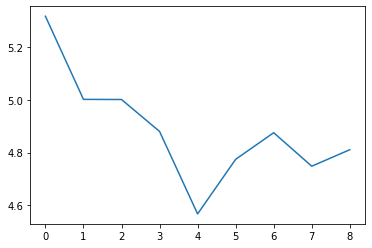

1m 9s (- 167m 48s) (2000 0%) 4.4764


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

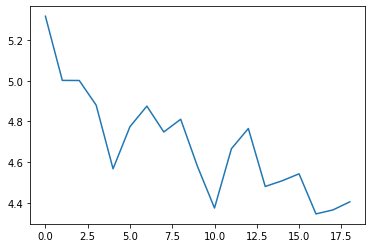

1m 37s (- 155m 3s) (3000 1%) 4.2783


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

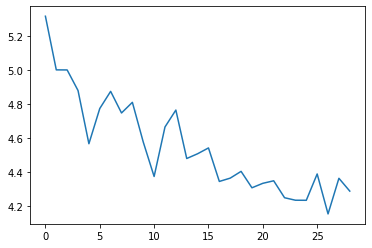

2m 5s (- 149m 8s) (4000 1%) 4.1453


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

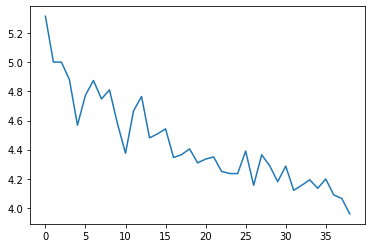

2m 32s (- 145m 7s) (5000 1%) 3.9709


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

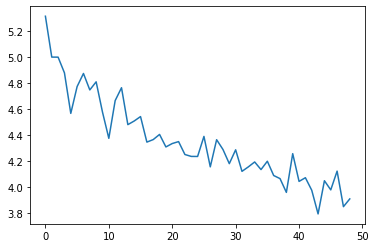

3m 0s (- 142m 42s) (6000 2%) 3.9119


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

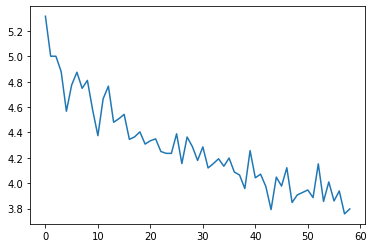

3m 28s (- 140m 43s) (7000 2%) 3.9139


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

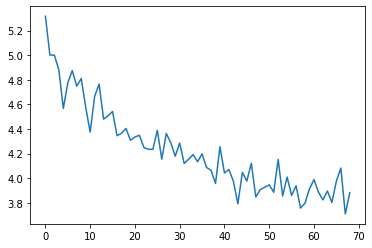

3m 56s (- 139m 9s) (8000 2%) 3.8323


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

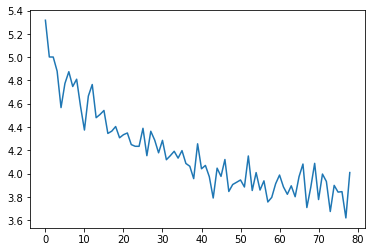

4m 25s (- 138m 3s) (9000 3%) 3.8122


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

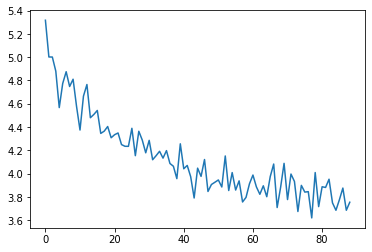

4m 53s (- 136m 57s) (10000 3%) 3.8172


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

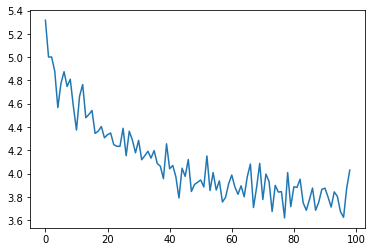

5m 21s (- 136m 0s) (11000 3%) 3.7531


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

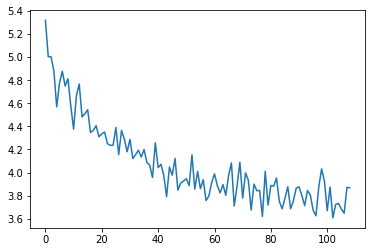

5m 49s (- 134m 59s) (12000 4%) 3.7824


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

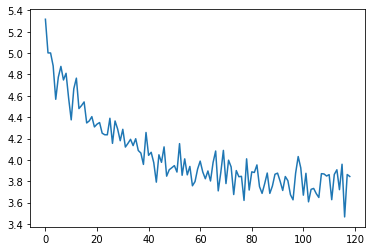

6m 17s (- 134m 11s) (13000 4%) 3.7797


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

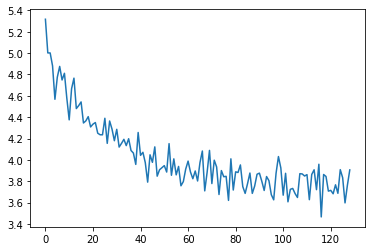

6m 46s (- 133m 26s) (14000 4%) 3.7715


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

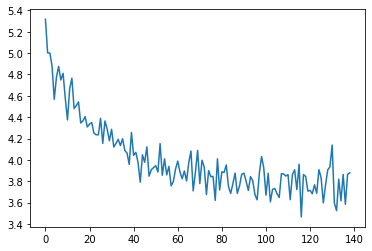

Epoch-15000 lr: 0.02
7m 13s (- 132m 35s) (15000 5%) 3.6559


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

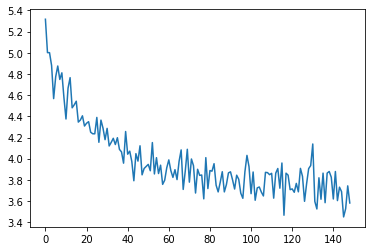

7m 41s (- 131m 48s) (16000 5%) 3.7228


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

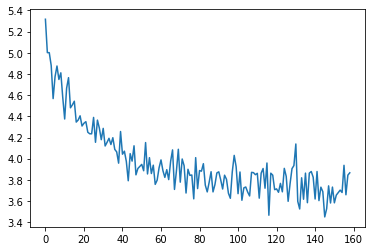

8m 9s (- 130m 58s) (17000 5%) 3.6657


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

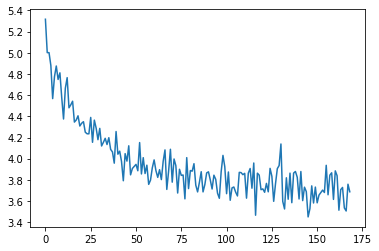

8m 37s (- 130m 18s) (18000 6%) 3.7499


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

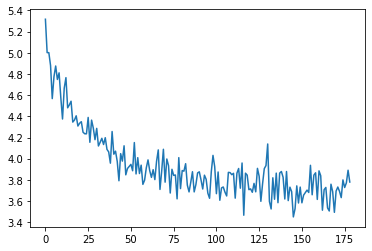

9m 5s (- 129m 39s) (19000 6%) 3.7007


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

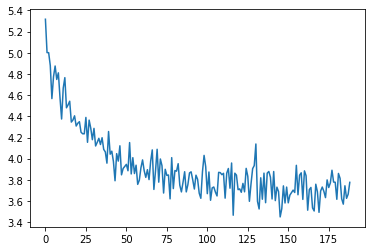

9m 33s (- 129m 1s) (20000 6%) 3.6684


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

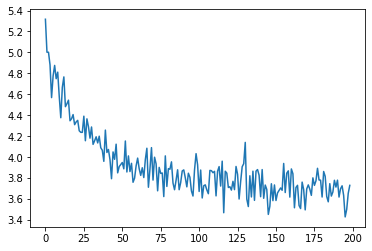

10m 1s (- 128m 22s) (21000 7%) 3.6607


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

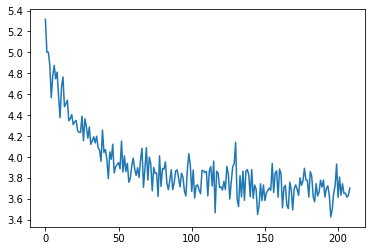

10m 29s (- 127m 50s) (22000 7%) 3.7100


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

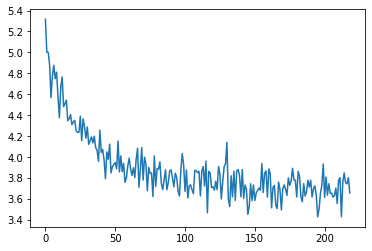

10m 57s (- 127m 11s) (23000 7%) 3.6006


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

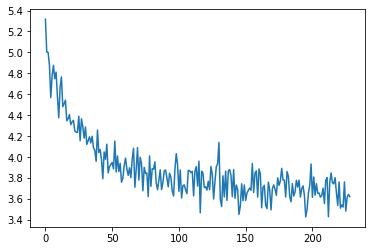

11m 25s (- 126m 39s) (24000 8%) 3.6671


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

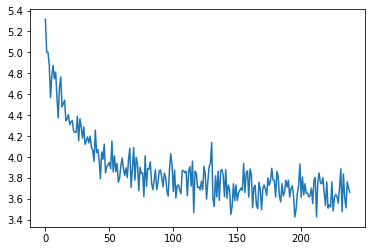

11m 54s (- 126m 10s) (25000 8%) 3.6465


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

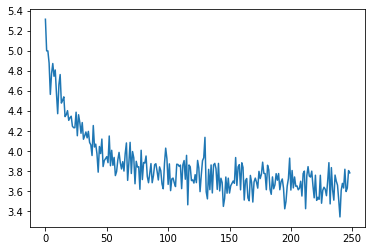

12m 22s (- 125m 37s) (26000 8%) 3.6451


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

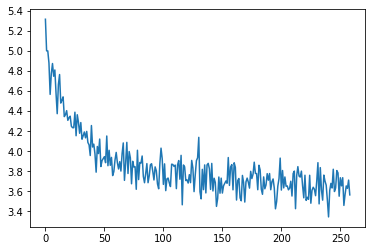

12m 50s (- 125m 7s) (27000 9%) 3.7058


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

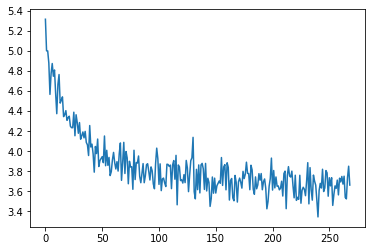

13m 19s (- 124m 36s) (28000 9%) 3.6839


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

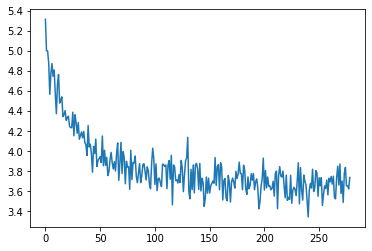

13m 46s (- 123m 59s) (29000 10%) 3.7065


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

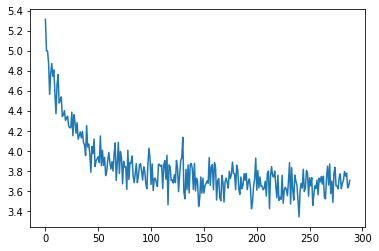

Epoch-1000 lr: 0.002
14m 14s (- 123m 27s) (30000 10%) 3.7070


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

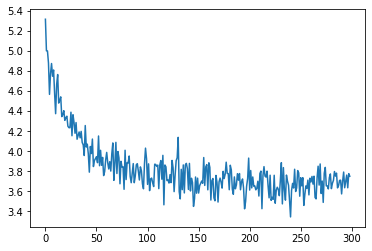

14m 42s (- 122m 56s) (31000 10%) 3.5329


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

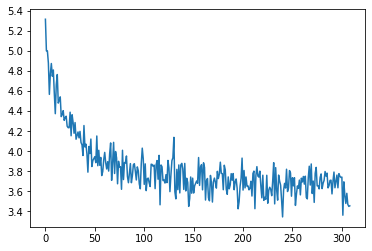

15m 11s (- 122m 25s) (32000 11%) 3.5297


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

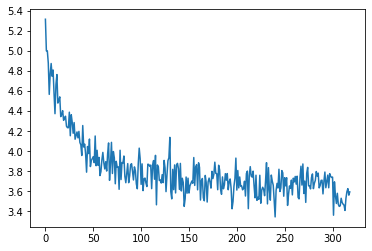

15m 39s (- 121m 54s) (33000 11%) 3.4331


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

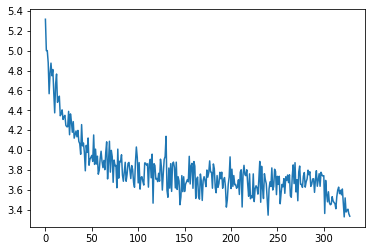

16m 7s (- 121m 24s) (34000 11%) 3.3863


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

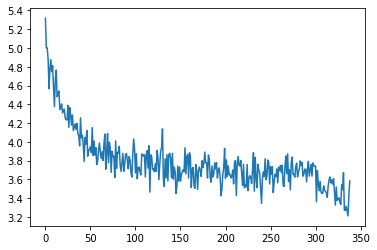

16m 35s (- 120m 52s) (35000 12%) 3.3932


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

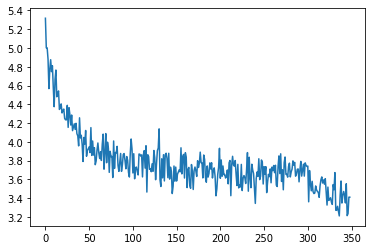

17m 3s (- 120m 22s) (36000 12%) 3.2981


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

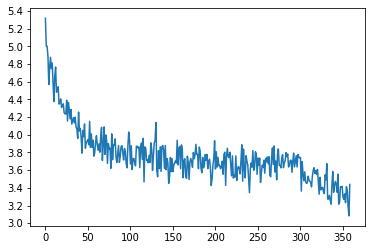

17m 31s (- 119m 51s) (37000 12%) 3.3682


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

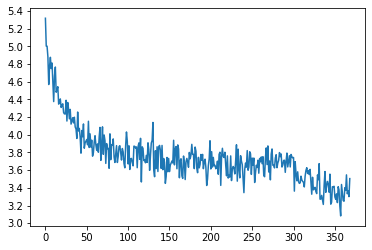

17m 59s (- 119m 21s) (38000 13%) 3.2486


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

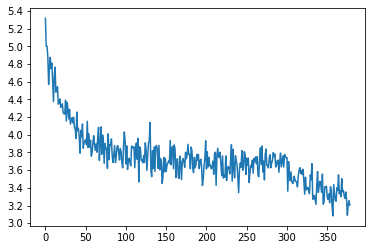

18m 28s (- 118m 52s) (39000 13%) 3.2955


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

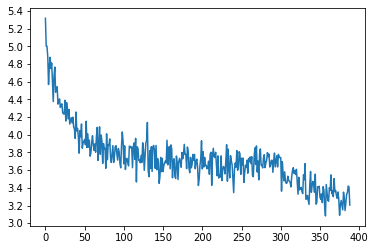

18m 56s (- 118m 21s) (40000 13%) 3.2643


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

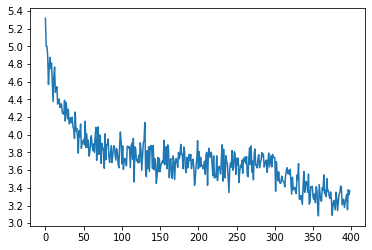

19m 24s (- 117m 53s) (41000 14%) 3.3269


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

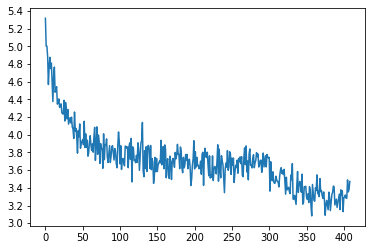

19m 53s (- 117m 24s) (42000 14%) 3.2212


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

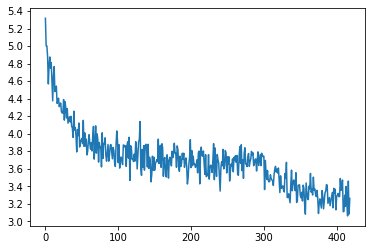

20m 21s (- 116m 56s) (43000 14%) 3.1863


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

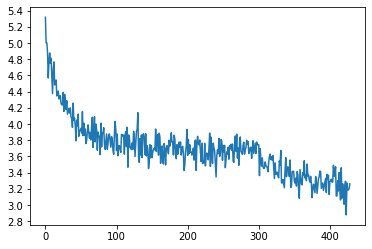

20m 50s (- 116m 29s) (44000 15%) 3.2561


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

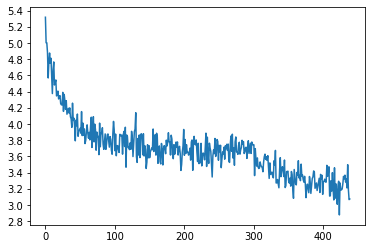

Epoch-16000 lr: 0.002
21m 18s (- 116m 1s) (45000 15%) 3.2581


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

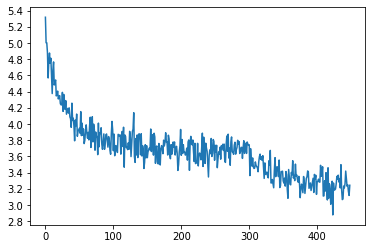

21m 47s (- 115m 34s) (46000 15%) 3.1675


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

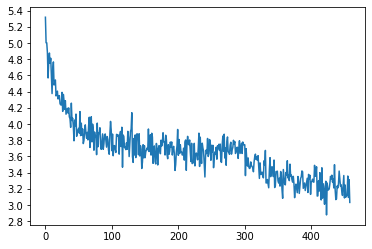

22m 15s (- 115m 7s) (47000 16%) 3.2294


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

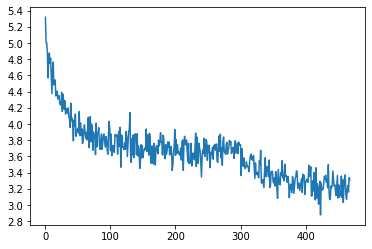

22m 44s (- 114m 40s) (48000 16%) 3.2190


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

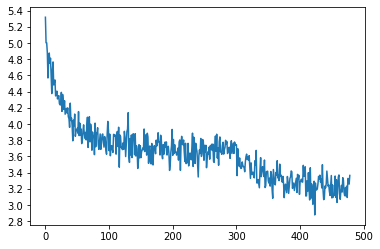

23m 13s (- 114m 14s) (49000 16%) 3.2981


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

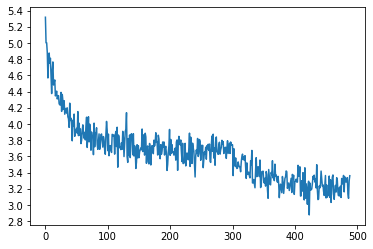

23m 42s (- 113m 47s) (50000 17%) 3.2313


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

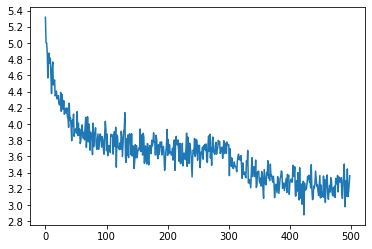

24m 11s (- 113m 21s) (51000 17%) 3.1273


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

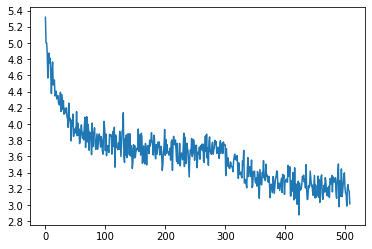

24m 40s (- 112m 54s) (52000 17%) 3.1325


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

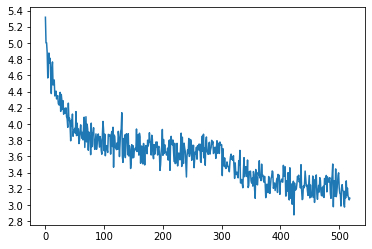

25m 8s (- 112m 26s) (53000 18%) 3.1603


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

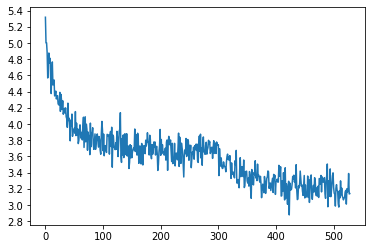

25m 37s (- 112m 0s) (54000 18%) 3.1880


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

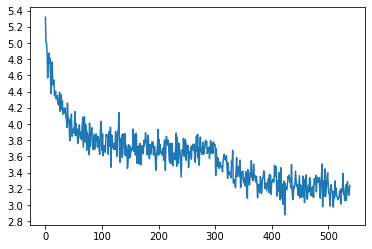

26m 6s (- 111m 33s) (55000 18%) 3.1768


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

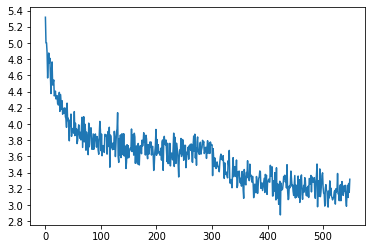

26m 35s (- 111m 7s) (56000 19%) 3.1900


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

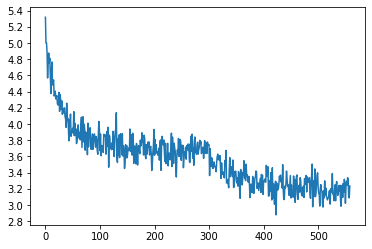

27m 4s (- 110m 39s) (57000 19%) 3.1823


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

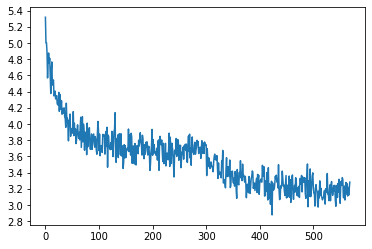

27m 32s (- 110m 9s) (58000 20%) 3.1141


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

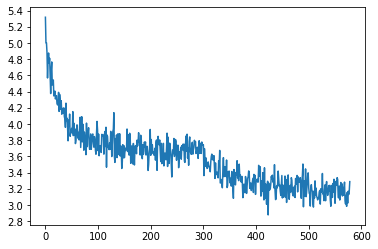

28m 1s (- 109m 44s) (59000 20%) 3.1342


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

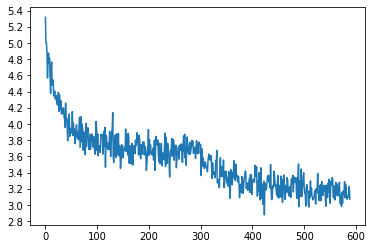

Epoch-2000 lr: 0.0002
28m 30s (- 109m 16s) (60000 20%) 3.0332


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

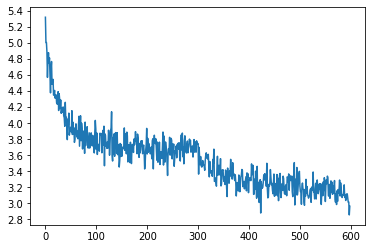

28m 59s (- 108m 51s) (61000 21%) 3.1410


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

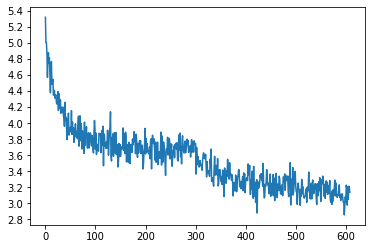

29m 28s (- 108m 25s) (62000 21%) 3.1142


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

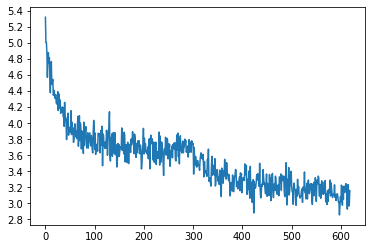

29m 57s (- 107m 57s) (63000 21%) 3.1620


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

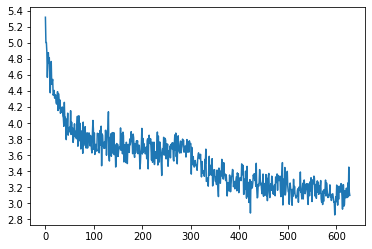

30m 26s (- 107m 31s) (64000 22%) 3.0944


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

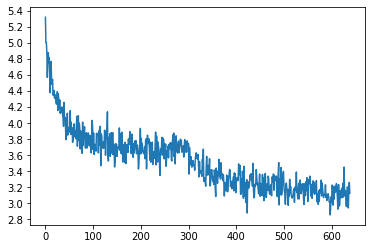

30m 55s (- 107m 3s) (65000 22%) 3.1422


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

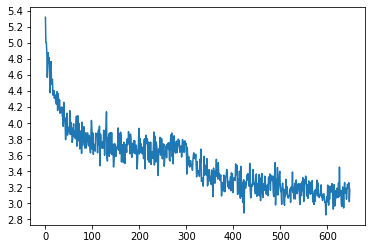

31m 24s (- 106m 36s) (66000 22%) 3.1517


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

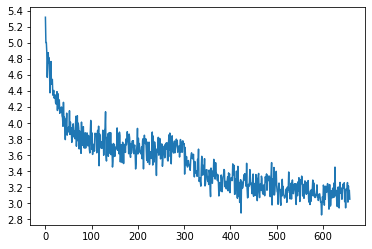

31m 53s (- 106m 8s) (67000 23%) 3.1058


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

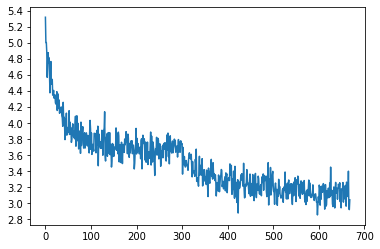

32m 22s (- 105m 40s) (68000 23%) 3.0768


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

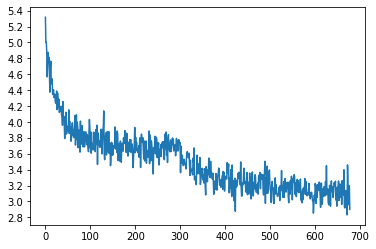

32m 50s (- 105m 11s) (69000 23%) 3.0797


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

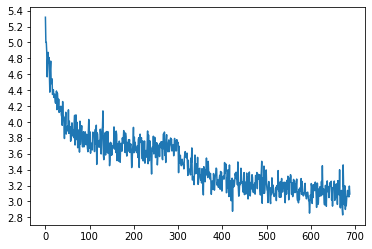

33m 19s (- 104m 43s) (70000 24%) 3.0962


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

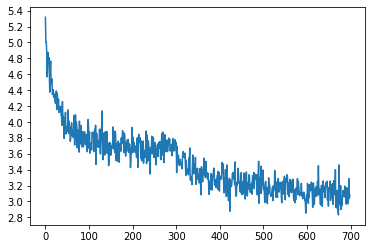

33m 47s (- 104m 14s) (71000 24%) 3.0588


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

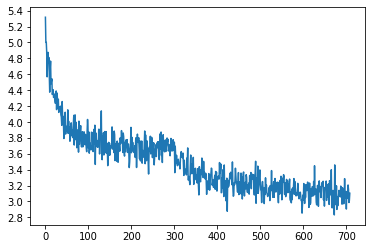

34m 16s (- 103m 45s) (72000 24%) 3.1225


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

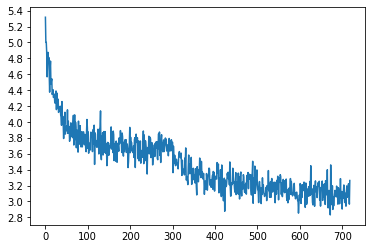

34m 45s (- 103m 18s) (73000 25%) 3.1290


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

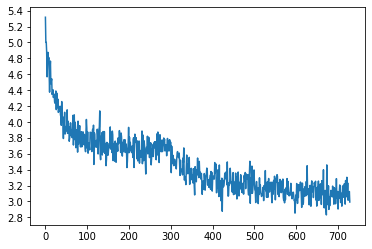

35m 13s (- 102m 48s) (74000 25%) 3.1019


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

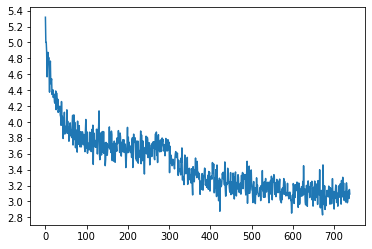

Epoch-17000 lr: 0.0002
35m 42s (- 102m 21s) (75000 25%) 3.0533


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

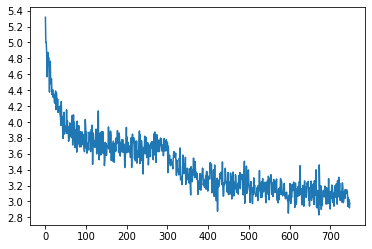

36m 11s (- 101m 53s) (76000 26%) 3.0529


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

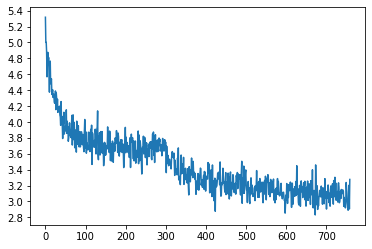

36m 39s (- 101m 23s) (77000 26%) 3.0564


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

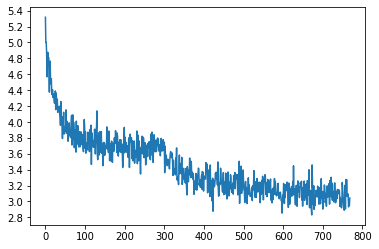

37m 8s (- 100m 55s) (78000 26%) 3.0839


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

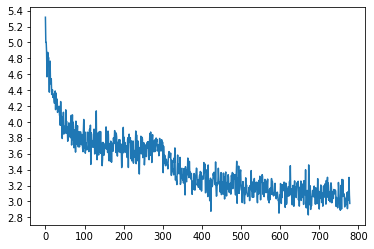

37m 36s (- 100m 26s) (79000 27%) 3.0750


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

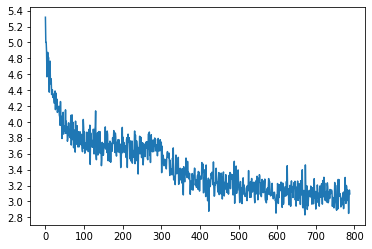

38m 4s (- 99m 57s) (80000 27%) 3.1620


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

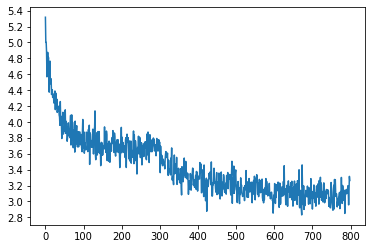

38m 33s (- 99m 28s) (81000 27%) 3.0762


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

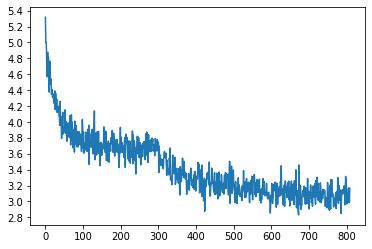

39m 1s (- 98m 59s) (82000 28%) 3.0784


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

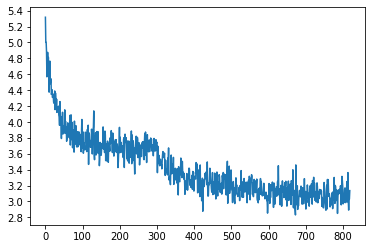

39m 29s (- 98m 29s) (83000 28%) 3.1167


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

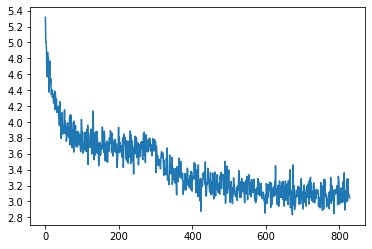

39m 58s (- 98m 0s) (84000 28%) 3.1049


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

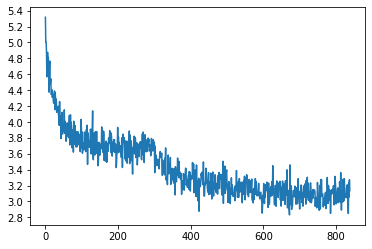

40m 26s (- 97m 32s) (85000 29%) 3.1381


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

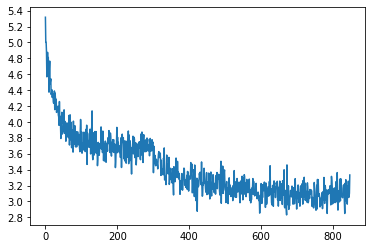

40m 54s (- 97m 2s) (86000 29%) 3.1017


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

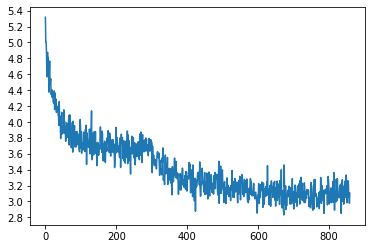

41m 23s (- 96m 34s) (87000 30%) 3.0568


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

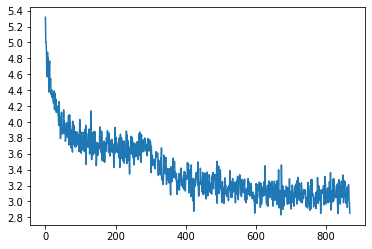

41m 51s (- 96m 4s) (88000 30%) 3.0646


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

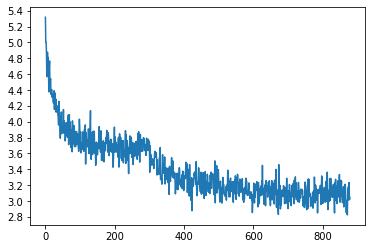

42m 19s (- 95m 34s) (89000 30%) 3.0449


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

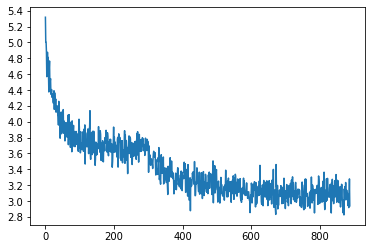

Epoch-3000 lr: 2e-05
42m 47s (- 95m 5s) (90000 31%) 3.1315


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

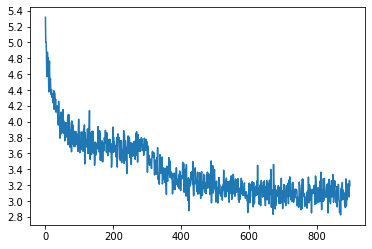

43m 15s (- 94m 36s) (91000 31%) 3.1304


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

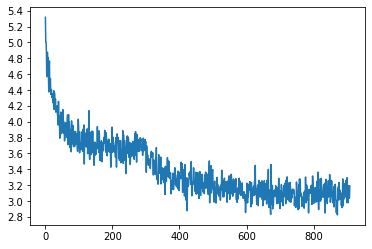

43m 44s (- 94m 7s) (92000 31%) 3.1606


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

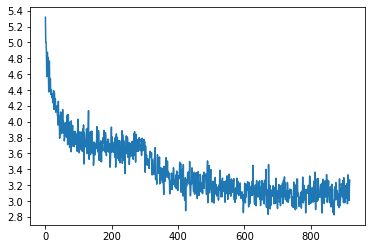

44m 12s (- 93m 38s) (93000 32%) 3.0787


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

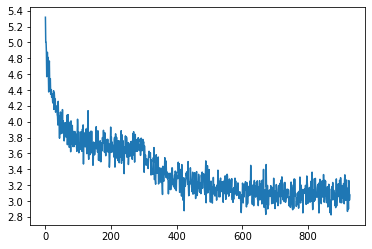

44m 40s (- 93m 9s) (94000 32%) 3.1305


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

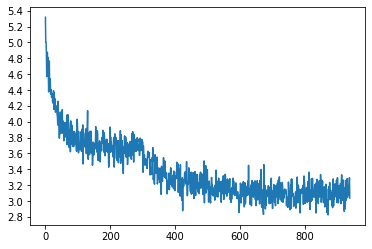

45m 9s (- 92m 41s) (95000 32%) 3.0980


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

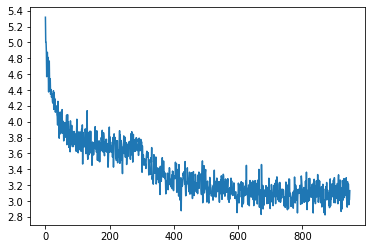

45m 37s (- 92m 12s) (96000 33%) 3.0916


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

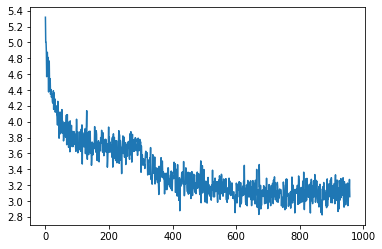

46m 5s (- 91m 42s) (97000 33%) 3.0769


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

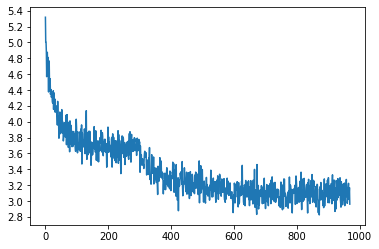

46m 34s (- 91m 14s) (98000 33%) 3.0729


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

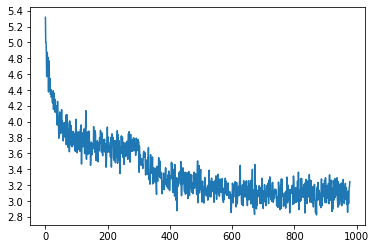

47m 2s (- 90m 45s) (99000 34%) 3.0565


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

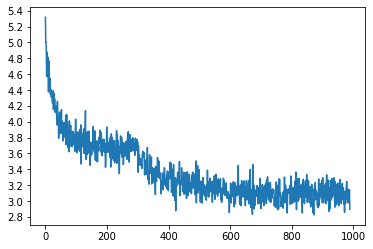

47m 30s (- 90m 16s) (100000 34%) 3.1281


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

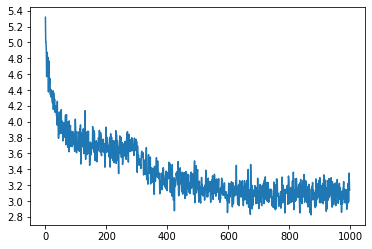

47m 58s (- 89m 46s) (101000 34%) 3.0292


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

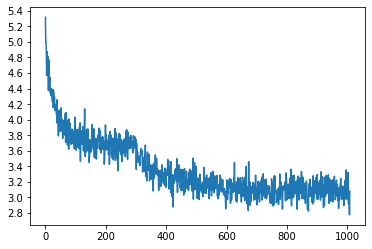

48m 27s (- 89m 18s) (102000 35%) 3.1633


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

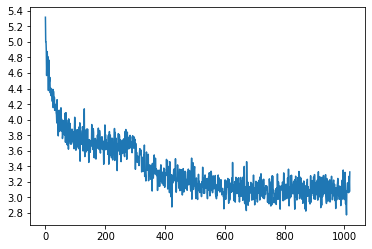

48m 56s (- 88m 50s) (103000 35%) 3.0740


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

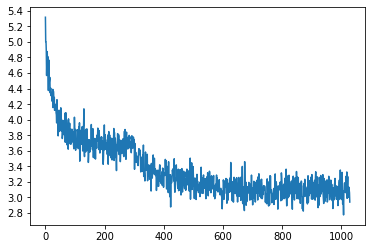

49m 24s (- 88m 21s) (104000 35%) 3.0980


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

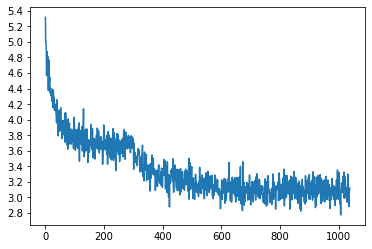

Epoch-18000 lr: 2e-05
49m 52s (- 87m 52s) (105000 36%) 3.0742


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

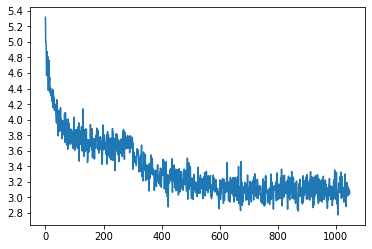

50m 20s (- 87m 23s) (106000 36%) 3.0447


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

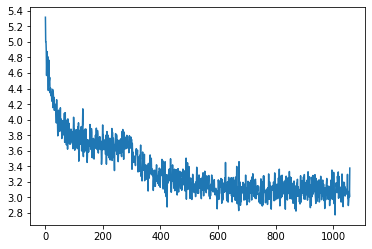

50m 48s (- 86m 53s) (107000 36%) 3.0785


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

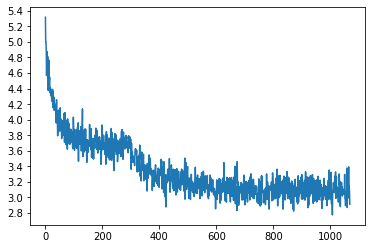

51m 17s (- 86m 25s) (108000 37%) 3.0419


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

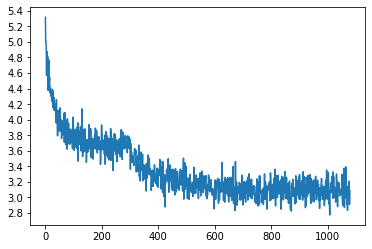

51m 45s (- 85m 56s) (109000 37%) 3.0943


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

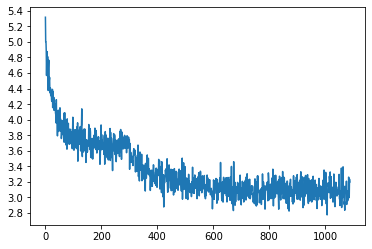

52m 13s (- 85m 27s) (110000 37%) 3.0183


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

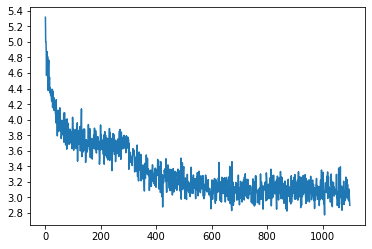

52m 41s (- 84m 58s) (111000 38%) 3.1050


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

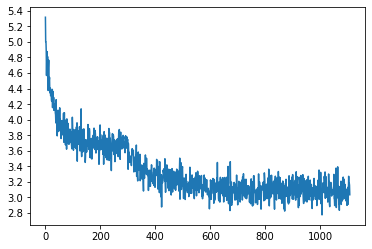

53m 10s (- 84m 30s) (112000 38%) 3.1248


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

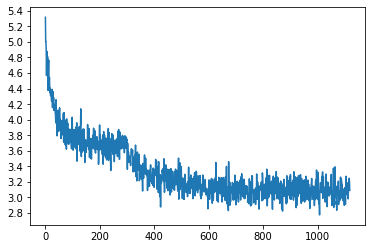

53m 38s (- 84m 1s) (113000 38%) 3.0999


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

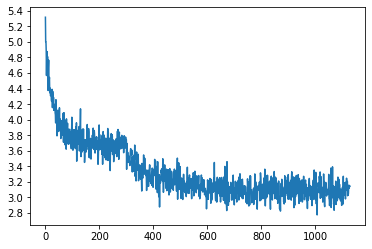

54m 7s (- 83m 33s) (114000 39%) 3.0489


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

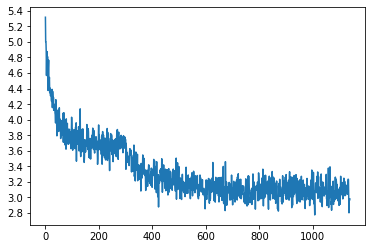

54m 35s (- 83m 4s) (115000 39%) 3.0841


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

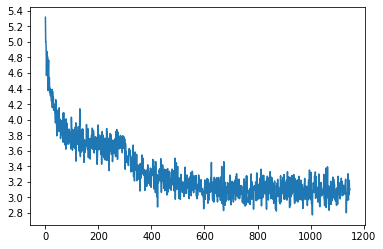

55m 3s (- 82m 35s) (116000 40%) 3.0797


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

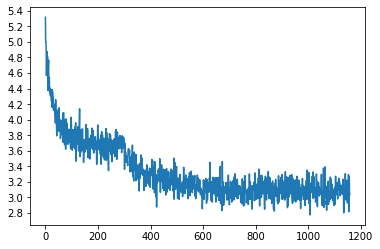

55m 31s (- 82m 6s) (117000 40%) 3.0111


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

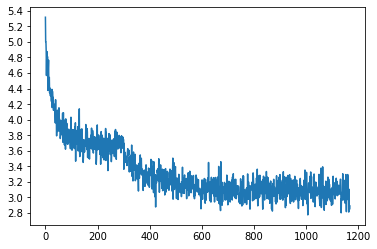

55m 59s (- 81m 37s) (118000 40%) 3.0393


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

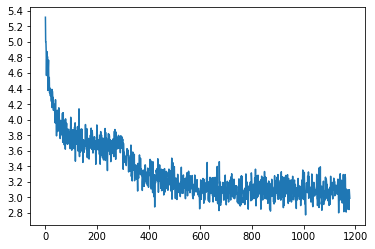

56m 27s (- 81m 8s) (119000 41%) 3.0875


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

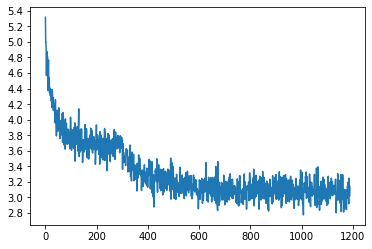

Epoch-4000 lr: 2.0000000000000003e-06
56m 56s (- 80m 39s) (120000 41%) 3.0734


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

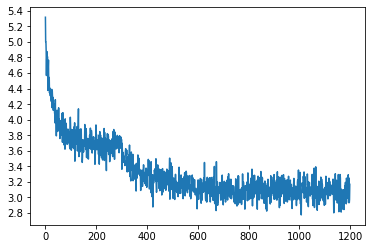

57m 24s (- 80m 10s) (121000 41%) 3.0915


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

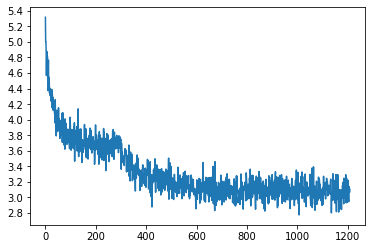

57m 52s (- 79m 42s) (122000 42%) 3.0958


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

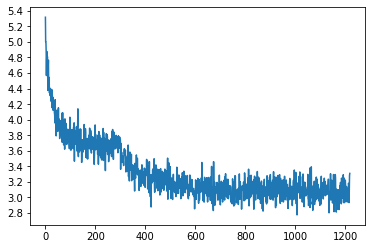

58m 21s (- 79m 14s) (123000 42%) 3.1077


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

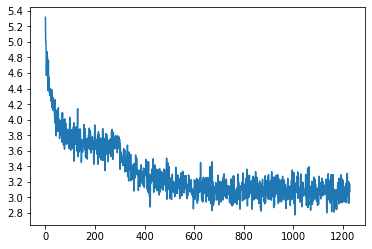

58m 50s (- 78m 46s) (124000 42%) 3.0770


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

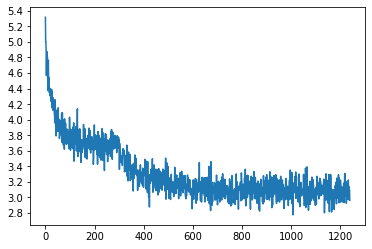

59m 19s (- 78m 18s) (125000 43%) 3.1586


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

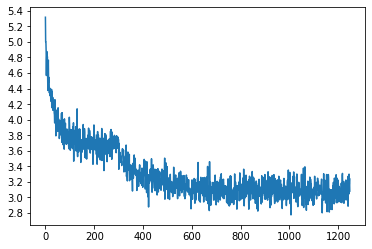

59m 48s (- 77m 50s) (126000 43%) 3.0870


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

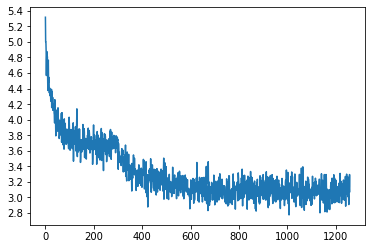

60m 16s (- 77m 22s) (127000 43%) 3.1320


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

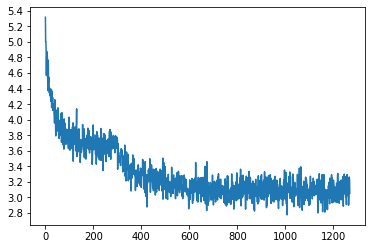

60m 45s (- 76m 53s) (128000 44%) 3.0584


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

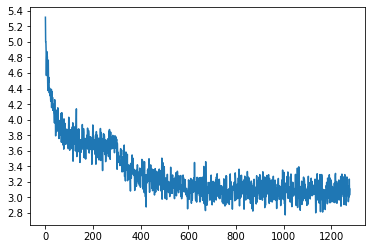

61m 14s (- 76m 25s) (129000 44%) 3.0789


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

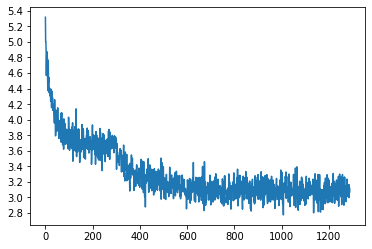

61m 43s (- 75m 57s) (130000 44%) 3.0245


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

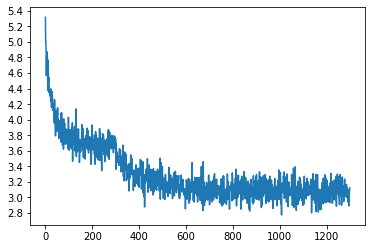

62m 11s (- 75m 29s) (131000 45%) 3.0623


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

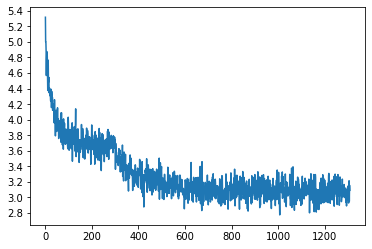

62m 40s (- 75m 1s) (132000 45%) 3.1049


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

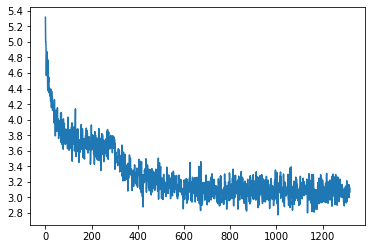

63m 9s (- 74m 33s) (133000 45%) 3.0509


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

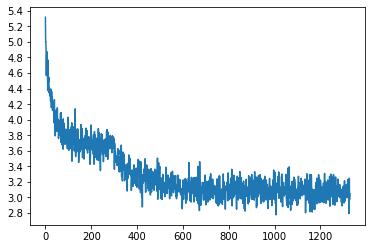

63m 38s (- 74m 5s) (134000 46%) 3.0743


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

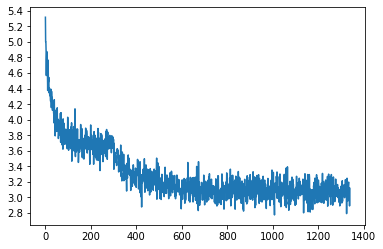

Epoch-19000 lr: 2.0000000000000003e-06
64m 7s (- 73m 38s) (135000 46%) 3.1187


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

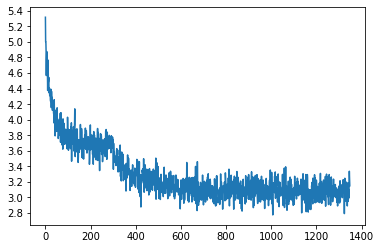

64m 37s (- 73m 10s) (136000 46%) 3.0457


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

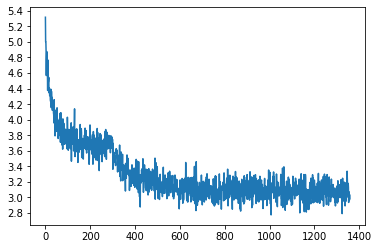

65m 6s (- 72m 42s) (137000 47%) 3.1041


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

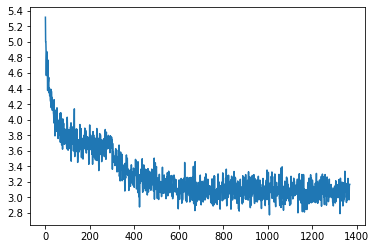

65m 35s (- 72m 14s) (138000 47%) 3.1221


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

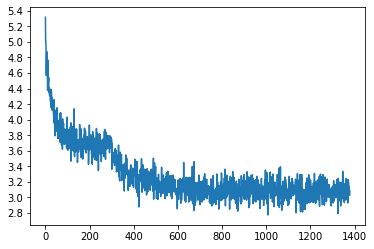

66m 4s (- 71m 46s) (139000 47%) 3.0641


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

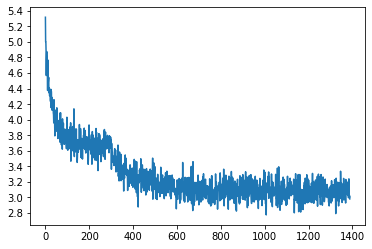

66m 32s (- 71m 18s) (140000 48%) 3.0745


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

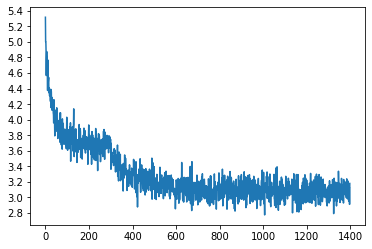

67m 2s (- 70m 50s) (141000 48%) 3.0824


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

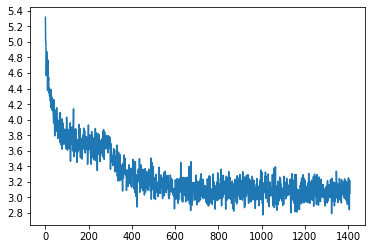

67m 30s (- 70m 22s) (142000 48%) 3.0612


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

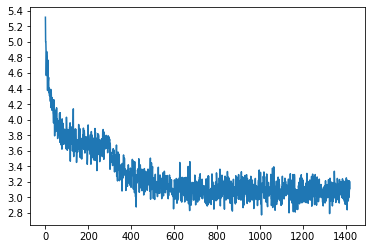

68m 0s (- 69m 54s) (143000 49%) 3.0491


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

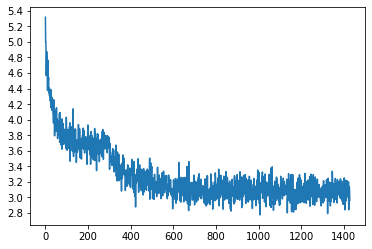

68m 28s (- 69m 26s) (144000 49%) 3.1266


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

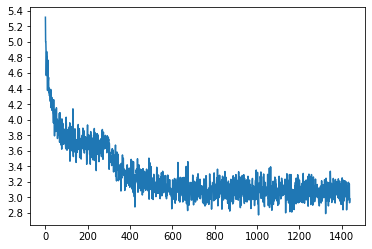

68m 57s (- 68m 57s) (145000 50%) 3.0482


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

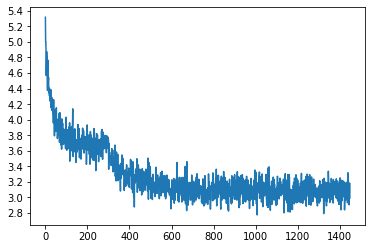

69m 26s (- 68m 29s) (146000 50%) 3.1164


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

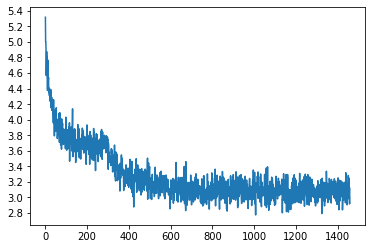

69m 55s (- 68m 1s) (147000 50%) 3.0074


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

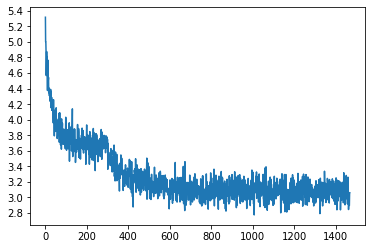

70m 24s (- 67m 33s) (148000 51%) 3.0913


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

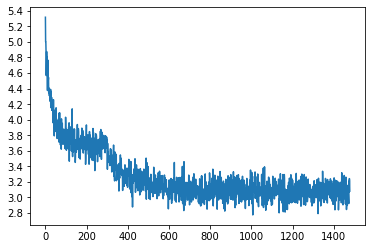

70m 53s (- 67m 5s) (149000 51%) 3.0572


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

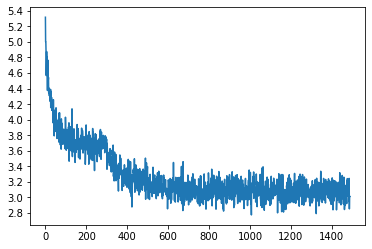

Epoch-5000 lr: 2.0000000000000004e-07
71m 22s (- 66m 37s) (150000 51%) 3.0746


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

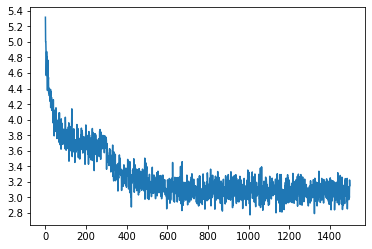

71m 51s (- 66m 9s) (151000 52%) 3.0921


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

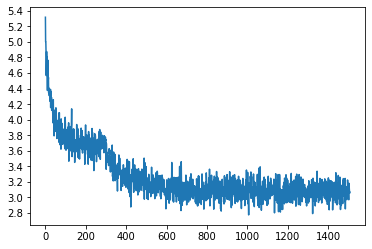

72m 20s (- 65m 40s) (152000 52%) 3.0545


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

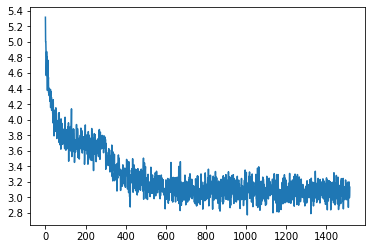

72m 48s (- 65m 11s) (153000 52%) 3.0882


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

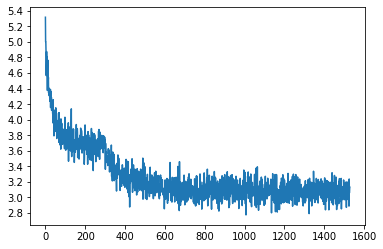

73m 16s (- 64m 42s) (154000 53%) 3.0168


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

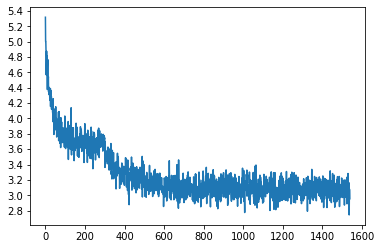

73m 44s (- 64m 13s) (155000 53%) 3.0847


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

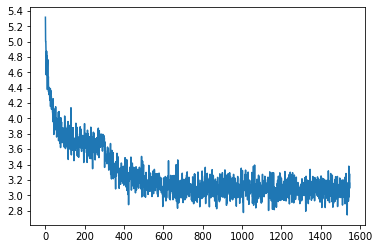

74m 12s (- 63m 44s) (156000 53%) 3.0336


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

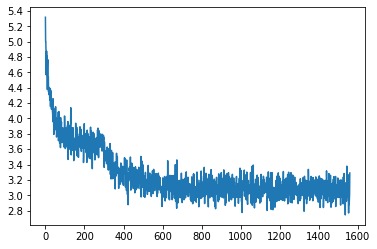

74m 40s (- 63m 15s) (157000 54%) 3.1158


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

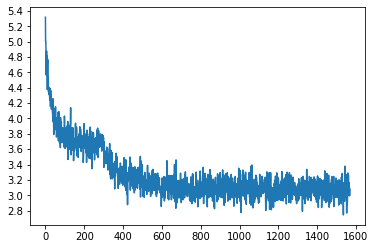

75m 8s (- 62m 46s) (158000 54%) 3.0666


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

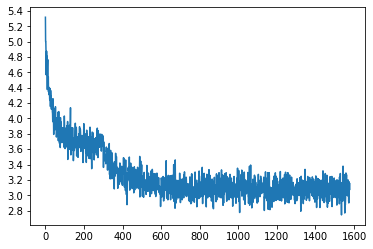

75m 36s (- 62m 17s) (159000 54%) 3.1240


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

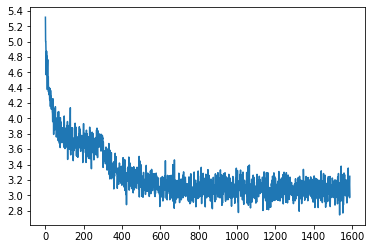

76m 5s (- 61m 49s) (160000 55%) 3.0609


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

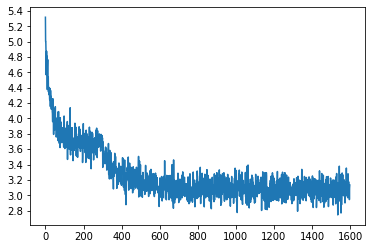

76m 34s (- 61m 21s) (161000 55%) 3.0742


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

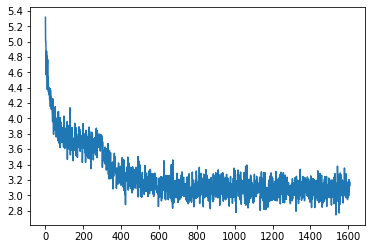

77m 3s (- 60m 53s) (162000 55%) 3.0795


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

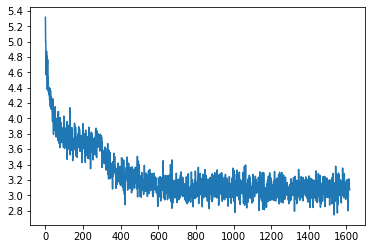

77m 33s (- 60m 25s) (163000 56%) 3.0157


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

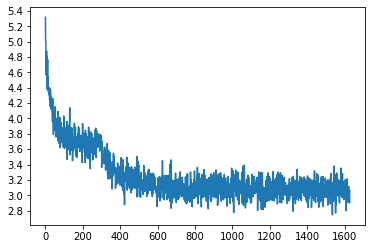

78m 2s (- 59m 57s) (164000 56%) 3.0768


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

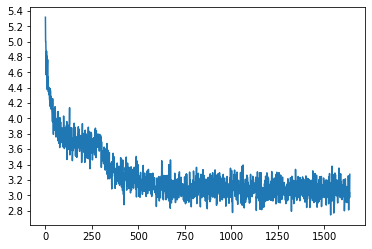

Epoch-20000 lr: 2.0000000000000004e-07
78m 31s (- 59m 29s) (165000 56%) 3.0681


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

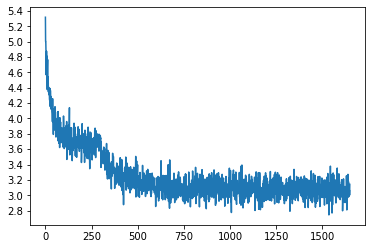

79m 0s (- 59m 1s) (166000 57%) 3.1303


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

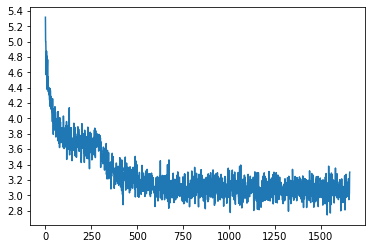

79m 30s (- 58m 33s) (167000 57%) 3.1154


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

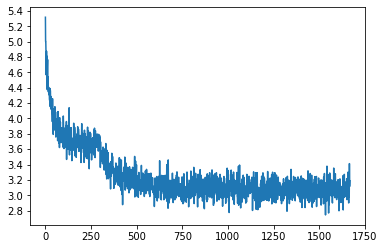

79m 59s (- 58m 5s) (168000 57%) 3.0801


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

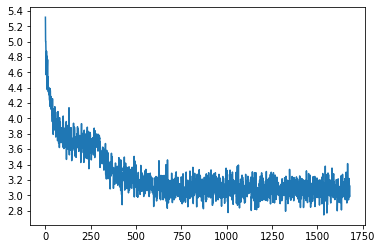

80m 28s (- 57m 36s) (169000 58%) 3.1259


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

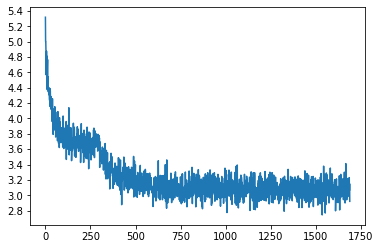

80m 57s (- 57m 8s) (170000 58%) 3.0936


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

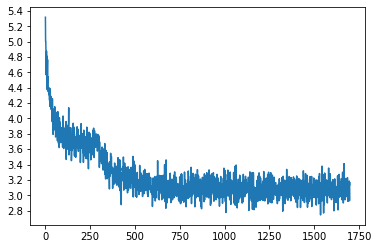

81m 26s (- 56m 40s) (171000 58%) 3.1023


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

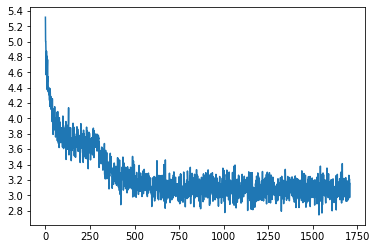

81m 55s (- 56m 12s) (172000 59%) 3.0665


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

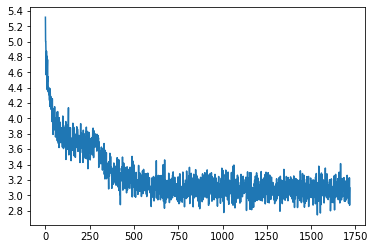

82m 24s (- 55m 43s) (173000 59%) 3.0954


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

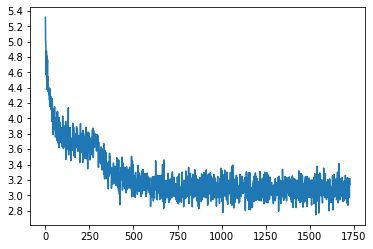

82m 53s (- 55m 15s) (174000 60%) 3.0283


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

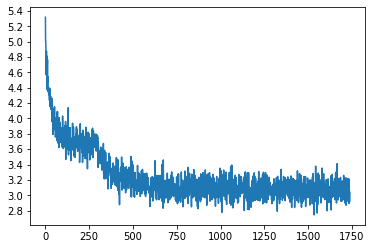

83m 22s (- 54m 47s) (175000 60%) 3.1985


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

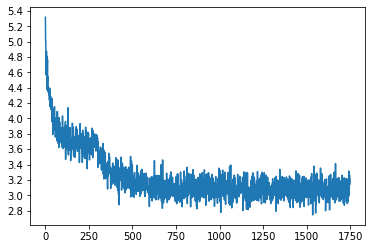

83m 51s (- 54m 19s) (176000 60%) 3.1470


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

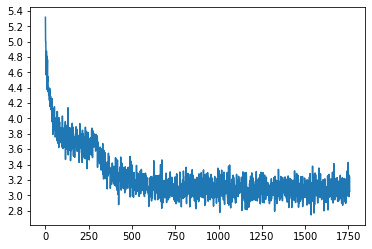

84m 20s (- 53m 50s) (177000 61%) 3.0486


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

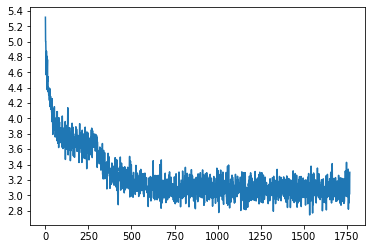

84m 48s (- 53m 21s) (178000 61%) 3.1115


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

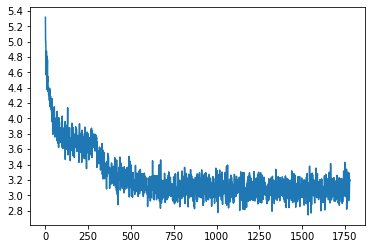

85m 17s (- 52m 53s) (179000 61%) 3.0868


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

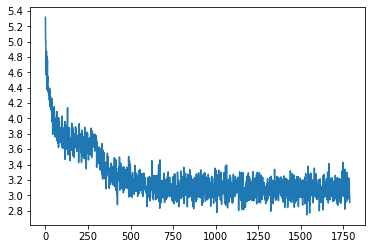

Epoch-6000 lr: 2.0000000000000007e-08
85m 46s (- 52m 25s) (180000 62%) 3.0066


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

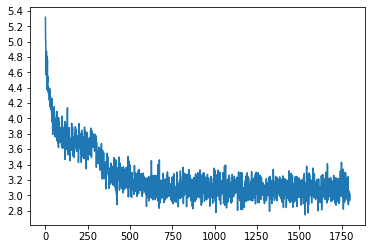

86m 15s (- 51m 56s) (181000 62%) 2.9969


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

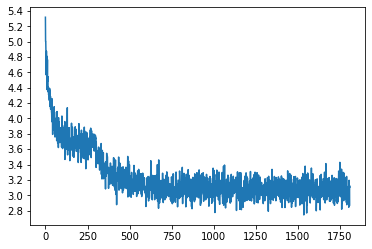

86m 44s (- 51m 28s) (182000 62%) 3.0908


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

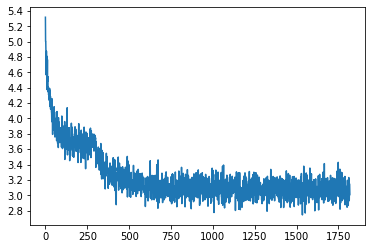

87m 13s (- 51m 0s) (183000 63%) 3.0904


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

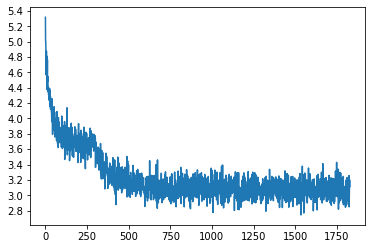

87m 43s (- 50m 31s) (184000 63%) 3.0923


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

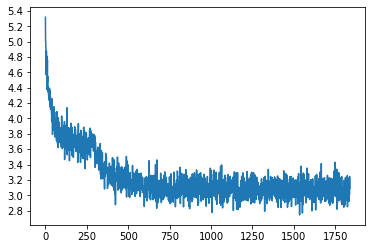

88m 12s (- 50m 3s) (185000 63%) 3.0515


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

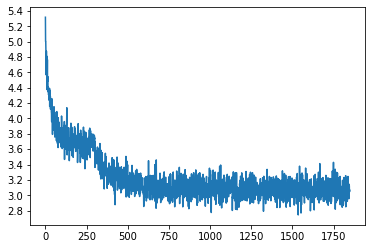

88m 41s (- 49m 35s) (186000 64%) 3.1486


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

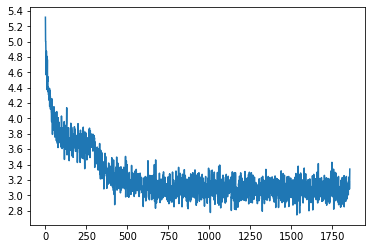

89m 9s (- 49m 6s) (187000 64%) 3.0877


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

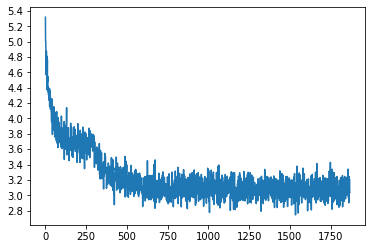

89m 38s (- 48m 38s) (188000 64%) 3.0770


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

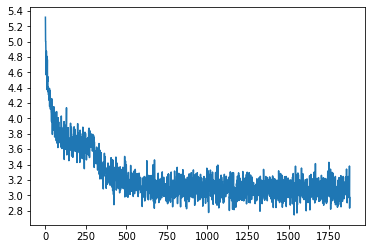

90m 6s (- 48m 9s) (189000 65%) 3.0366


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

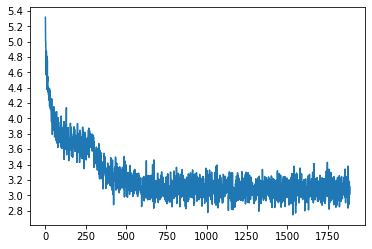

90m 34s (- 47m 40s) (190000 65%) 3.0257


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

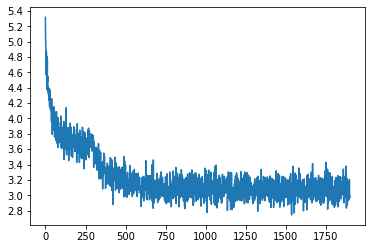

91m 2s (- 47m 11s) (191000 65%) 3.0098


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

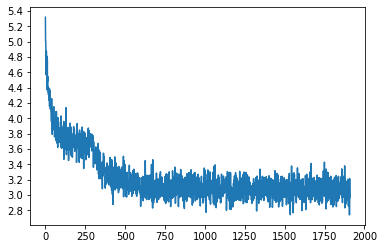

91m 30s (- 46m 42s) (192000 66%) 3.0569


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

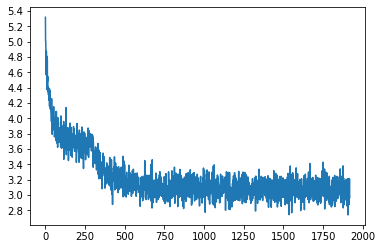

91m 58s (- 46m 13s) (193000 66%) 3.0766


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

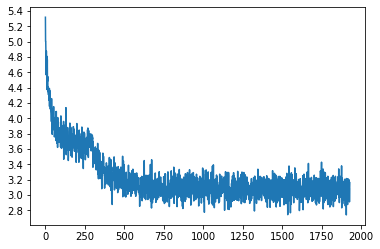

92m 26s (- 45m 44s) (194000 66%) 3.1103


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

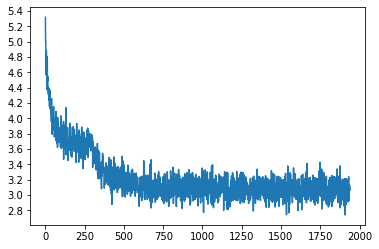

Epoch-21000 lr: 2.0000000000000007e-08
92m 54s (- 45m 16s) (195000 67%) 3.1018


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

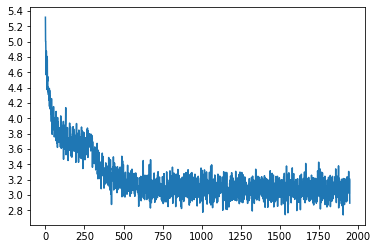

93m 23s (- 44m 47s) (196000 67%) 3.0422


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

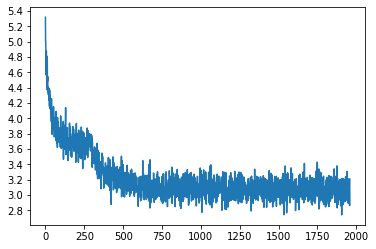

93m 51s (- 44m 18s) (197000 67%) 3.1012


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

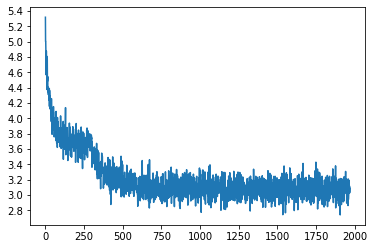

94m 19s (- 43m 49s) (198000 68%) 3.0835


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

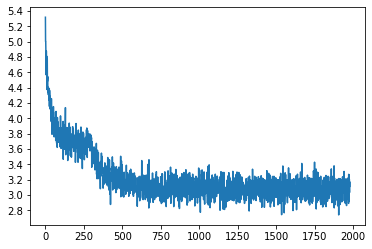

94m 47s (- 43m 20s) (199000 68%) 3.1018


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

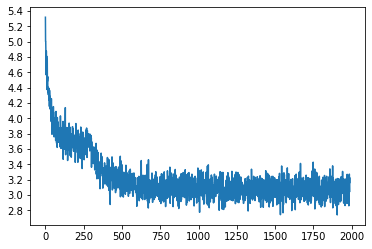

95m 16s (- 42m 52s) (200000 68%) 3.0990


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

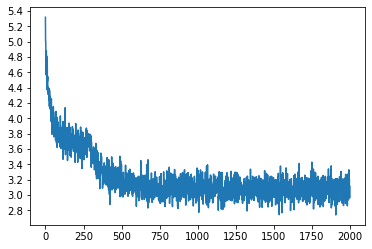

95m 44s (- 42m 23s) (201000 69%) 3.1173


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

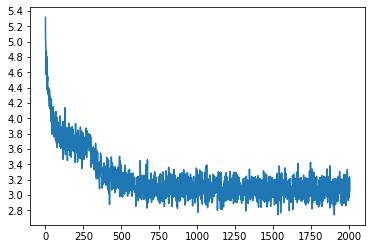

96m 12s (- 41m 54s) (202000 69%) 3.0721


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

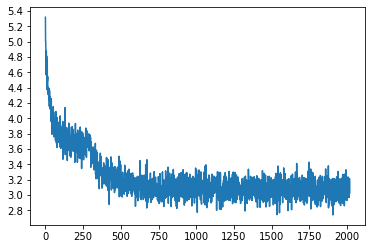

96m 40s (- 41m 25s) (203000 70%) 3.0568


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

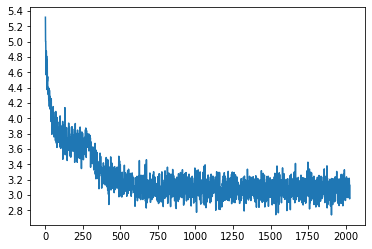

97m 8s (- 40m 57s) (204000 70%) 3.0698


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

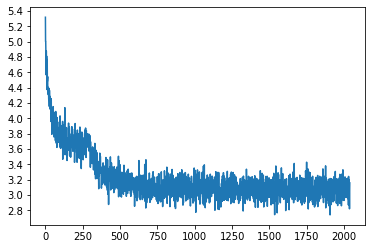

97m 36s (- 40m 28s) (205000 70%) 3.0950


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

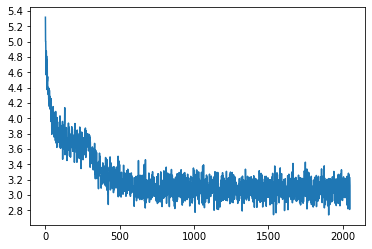

98m 5s (- 39m 59s) (206000 71%) 3.0586


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

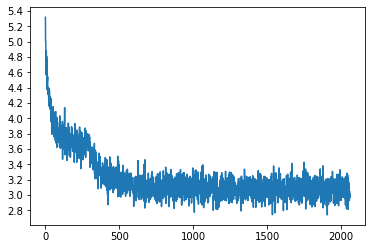

98m 33s (- 39m 31s) (207000 71%) 3.0825


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

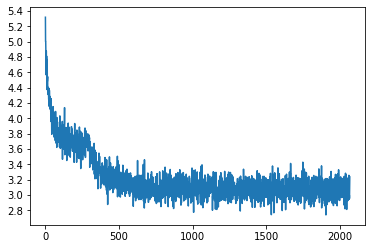

99m 1s (- 39m 2s) (208000 71%) 3.1042


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

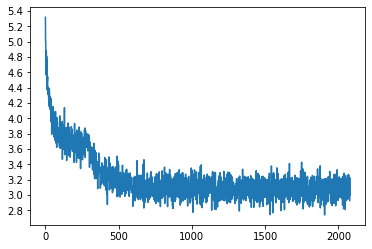

99m 29s (- 38m 33s) (209000 72%) 3.1524


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

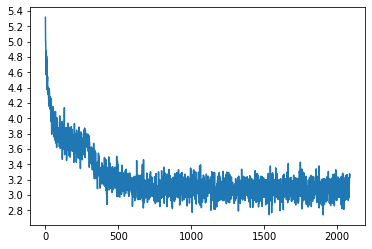

Epoch-7000 lr: 2.000000000000001e-09
99m 58s (- 38m 4s) (210000 72%) 3.0776


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

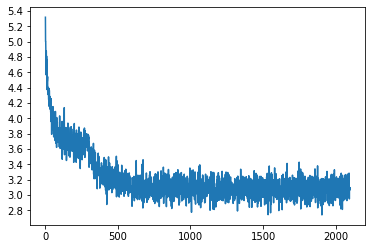

100m 26s (- 37m 36s) (211000 72%) 3.0614


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

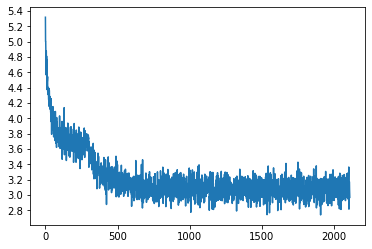

100m 54s (- 37m 7s) (212000 73%) 3.1452


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

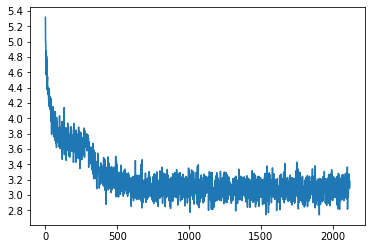

101m 22s (- 36m 38s) (213000 73%) 3.1596


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

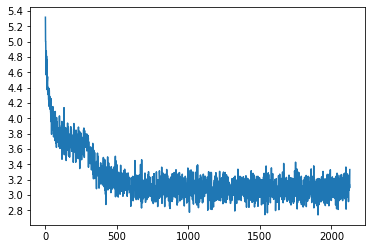

101m 50s (- 36m 10s) (214000 73%) 3.1112


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

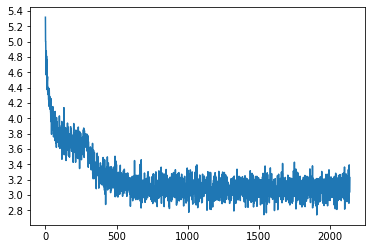

102m 18s (- 35m 41s) (215000 74%) 3.0785


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

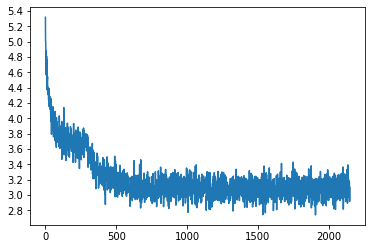

102m 46s (- 35m 12s) (216000 74%) 3.1069


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

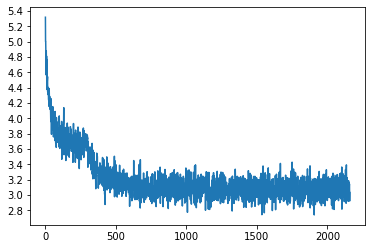

103m 15s (- 34m 44s) (217000 74%) 3.0932


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

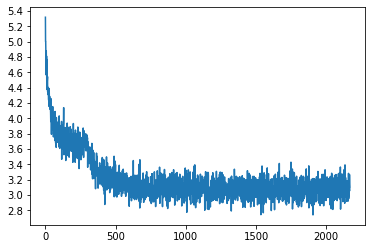

103m 44s (- 34m 15s) (218000 75%) 3.0946


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

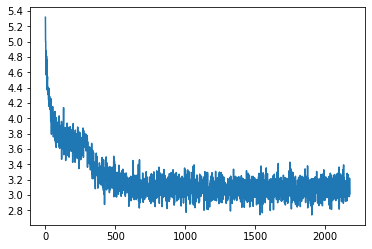

104m 12s (- 33m 47s) (219000 75%) 3.1297


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

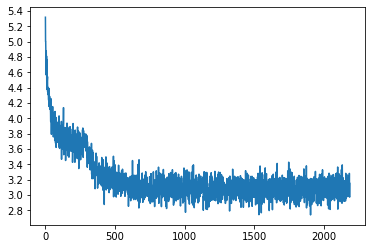

104m 41s (- 33m 18s) (220000 75%) 3.1000


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

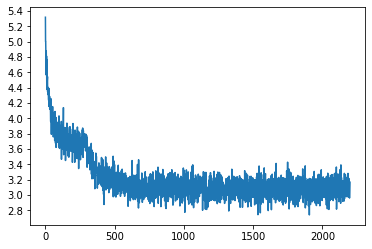

105m 9s (- 32m 49s) (221000 76%) 3.0230


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

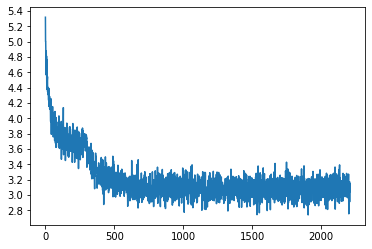

105m 37s (- 32m 21s) (222000 76%) 3.1207


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

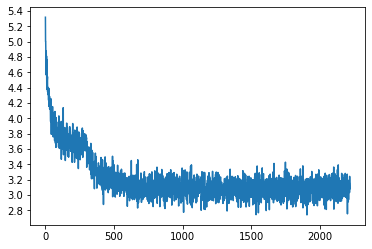

106m 5s (- 31m 52s) (223000 76%) 3.0553


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

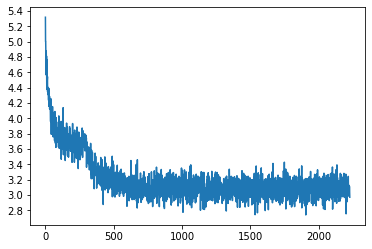

106m 33s (- 31m 23s) (224000 77%) 3.0550


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

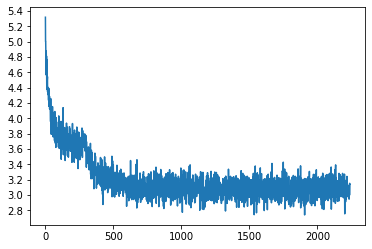

Epoch-22000 lr: 2.000000000000001e-09
107m 1s (- 30m 55s) (225000 77%) 3.0643


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

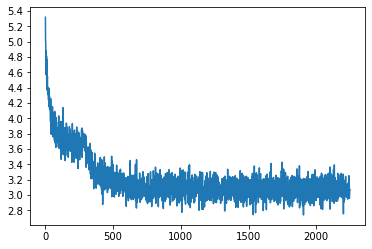

107m 30s (- 30m 26s) (226000 77%) 3.1072


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

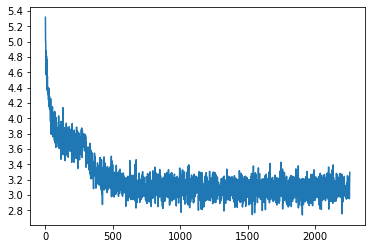

107m 58s (- 29m 58s) (227000 78%) 3.1096


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

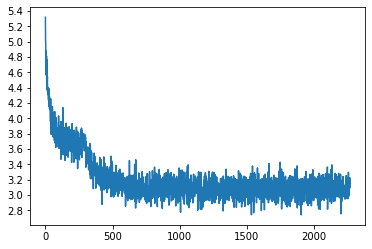

108m 27s (- 29m 29s) (228000 78%) 3.0696


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

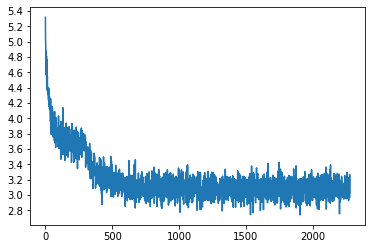

108m 55s (- 29m 0s) (229000 78%) 3.0796


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

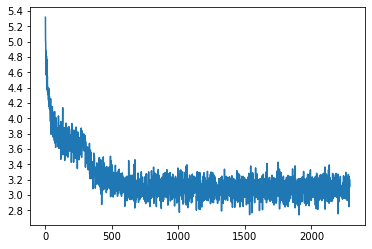

109m 23s (- 28m 32s) (230000 79%) 3.0991


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

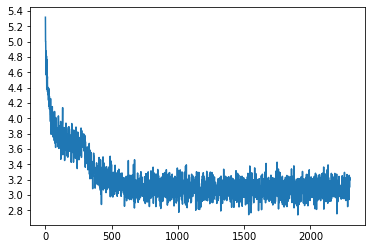

109m 51s (- 28m 3s) (231000 79%) 3.1238


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

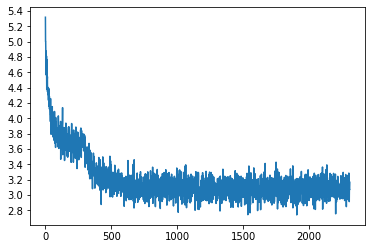

110m 19s (- 27m 34s) (232000 80%) 3.1244


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

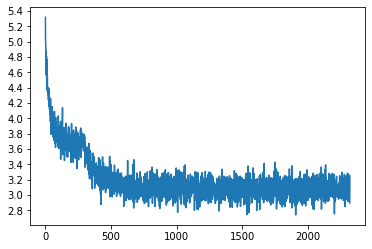

110m 48s (- 27m 6s) (233000 80%) 3.0712


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

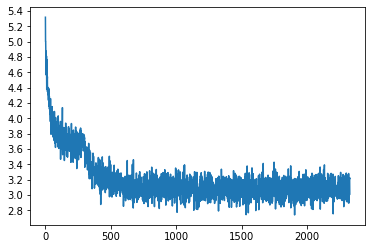

111m 17s (- 26m 37s) (234000 80%) 3.0258


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

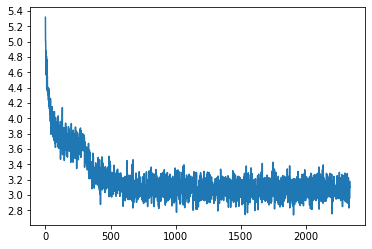

111m 45s (- 26m 9s) (235000 81%) 3.0614


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

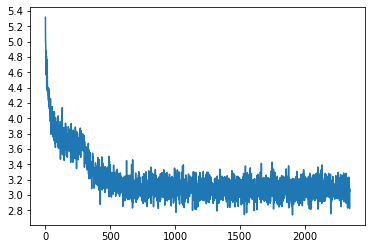

112m 13s (- 25m 40s) (236000 81%) 3.0918


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

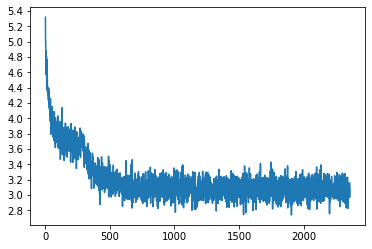

112m 41s (- 25m 11s) (237000 81%) 3.0799


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

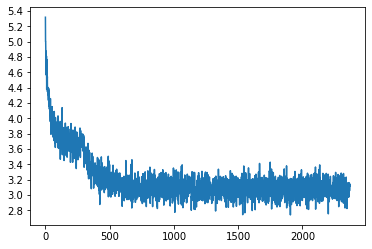

113m 9s (- 24m 43s) (238000 82%) 3.1131


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

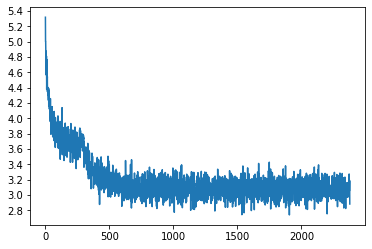

113m 37s (- 24m 14s) (239000 82%) 3.1134


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

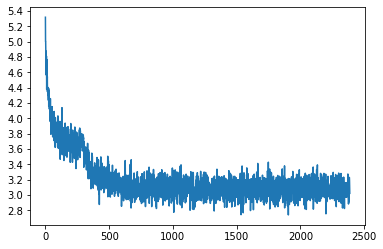

Epoch-8000 lr: 2.000000000000001e-10
114m 5s (- 23m 46s) (240000 82%) 3.0603


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

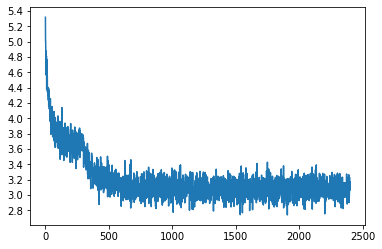

114m 34s (- 23m 17s) (241000 83%) 3.1879


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

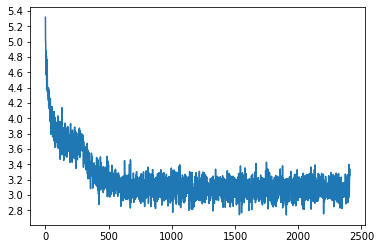

115m 2s (- 22m 49s) (242000 83%) 3.1393


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

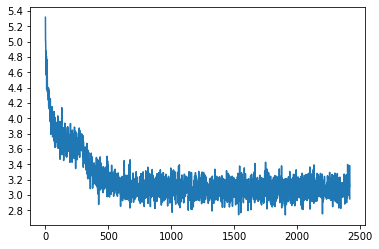

115m 31s (- 22m 20s) (243000 83%) 3.1591


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

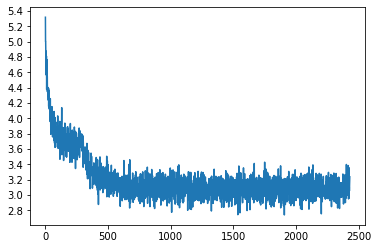

115m 59s (- 21m 51s) (244000 84%) 3.0716


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

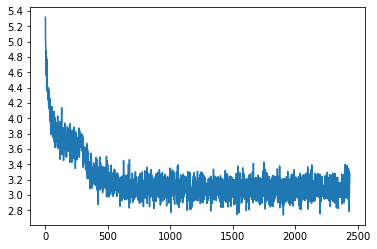

116m 27s (- 21m 23s) (245000 84%) 3.1125


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

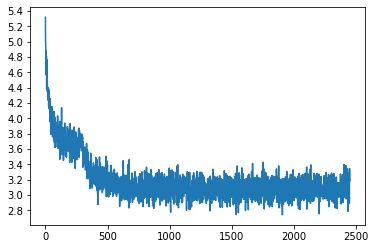

116m 55s (- 20m 54s) (246000 84%) 3.1362


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

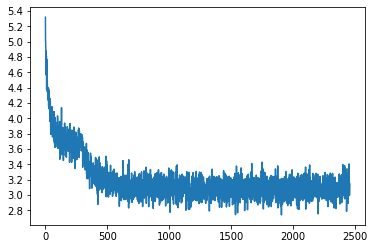

117m 24s (- 20m 26s) (247000 85%) 3.0875


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

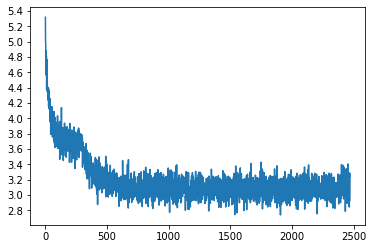

117m 52s (- 19m 57s) (248000 85%) 3.0477


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

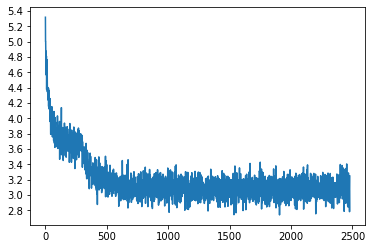

118m 20s (- 19m 29s) (249000 85%) 3.0732


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

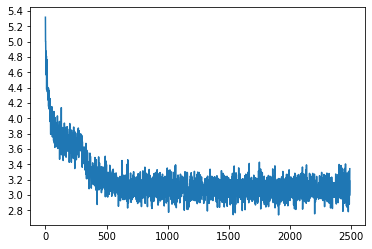

118m 48s (- 19m 0s) (250000 86%) 3.0938


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

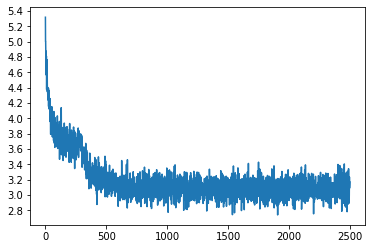

119m 17s (- 18m 32s) (251000 86%) 3.0715


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

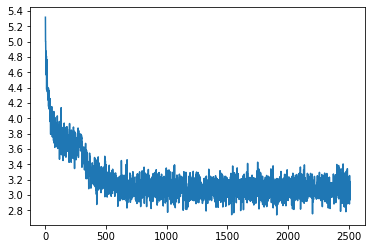

119m 45s (- 18m 3s) (252000 86%) 3.1363


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

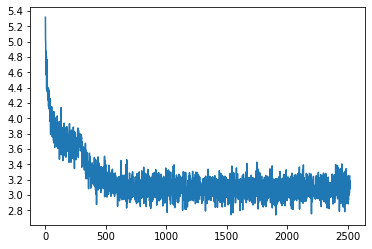

120m 13s (- 17m 34s) (253000 87%) 3.0748


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

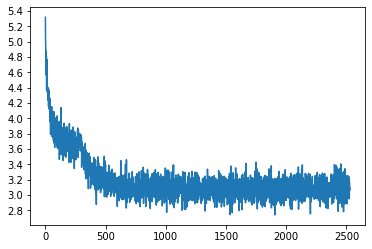

120m 42s (- 17m 6s) (254000 87%) 3.0419


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

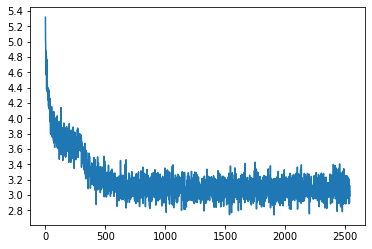

Epoch-23000 lr: 2.000000000000001e-10
121m 11s (- 16m 38s) (255000 87%) 3.0728


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

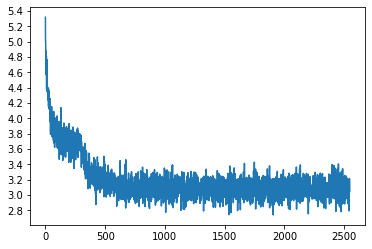

121m 40s (- 16m 9s) (256000 88%) 3.0668


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

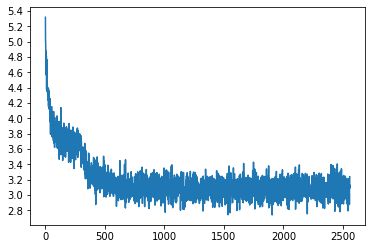

122m 9s (- 15m 41s) (257000 88%) 3.1176


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

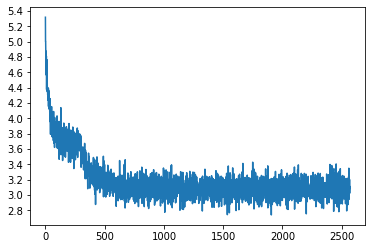

122m 37s (- 15m 12s) (258000 88%) 3.0420


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

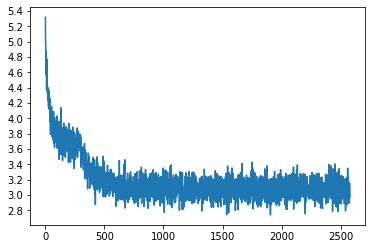

123m 6s (- 14m 44s) (259000 89%) 3.0506


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

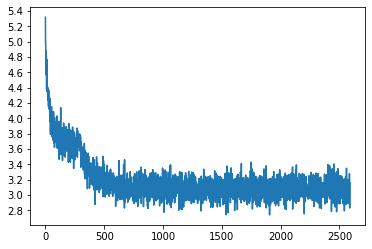

123m 35s (- 14m 15s) (260000 89%) 3.0915


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

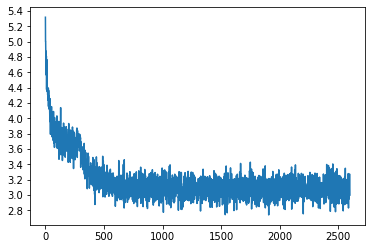

124m 4s (- 13m 47s) (261000 90%) 3.1221


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

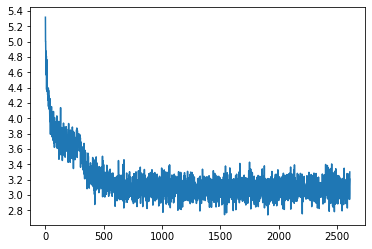

124m 33s (- 13m 18s) (262000 90%) 3.1130


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

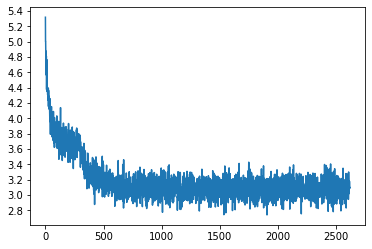

125m 2s (- 12m 50s) (263000 90%) 3.0479


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

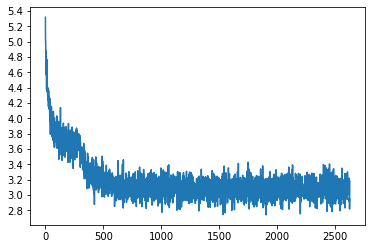

125m 31s (- 12m 21s) (264000 91%) 3.1165


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

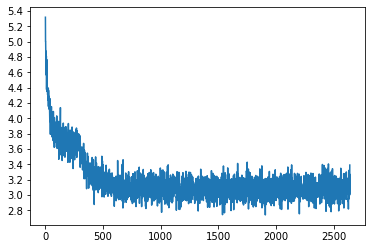

126m 0s (- 11m 53s) (265000 91%) 3.0908


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

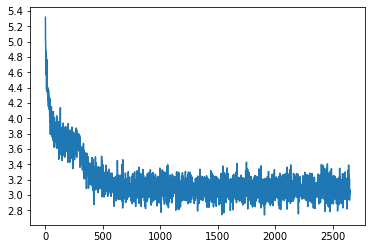

126m 29s (- 11m 24s) (266000 91%) 3.0448


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

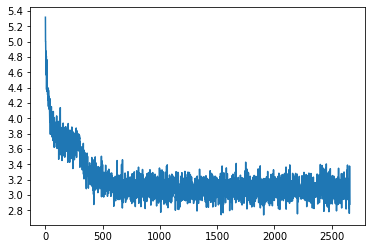

126m 58s (- 10m 56s) (267000 92%) 3.0867


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

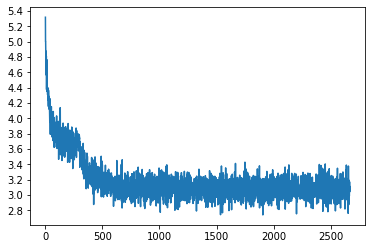

127m 27s (- 10m 27s) (268000 92%) 3.0629


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

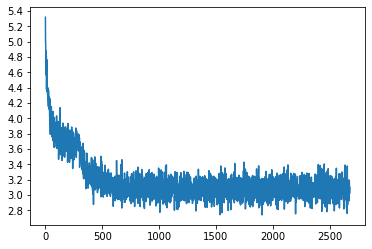

127m 56s (- 9m 59s) (269000 92%) 3.0529


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

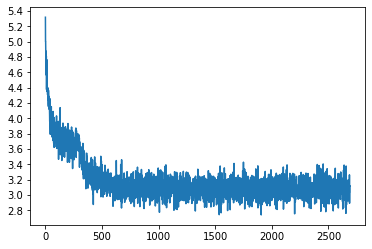

Epoch-9000 lr: 2.0000000000000012e-11
128m 25s (- 9m 30s) (270000 93%) 3.0807


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

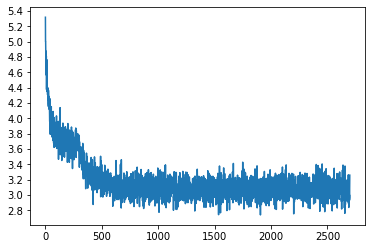

128m 55s (- 9m 2s) (271000 93%) 3.1195


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

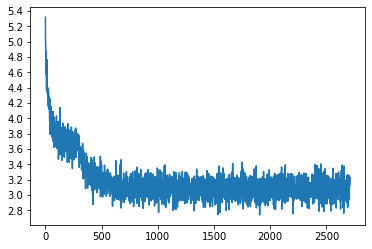

129m 24s (- 8m 33s) (272000 93%) 3.1427


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

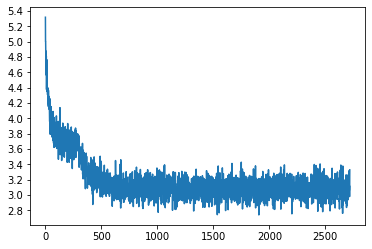

129m 54s (- 8m 5s) (273000 94%) 3.0700


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

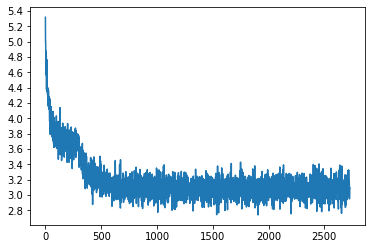

130m 23s (- 7m 36s) (274000 94%) 3.0717


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

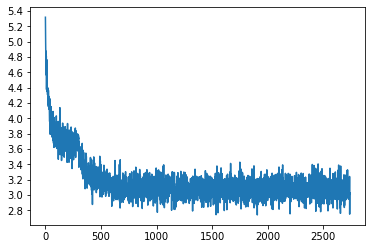

130m 53s (- 7m 8s) (275000 94%) 3.0932


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

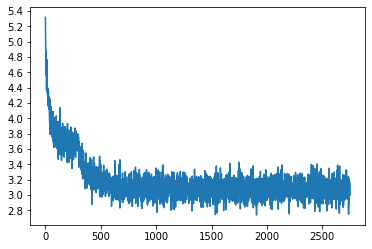

131m 22s (- 6m 39s) (276000 95%) 3.0231


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

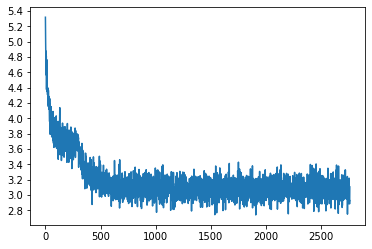

131m 51s (- 6m 11s) (277000 95%) 3.1350


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

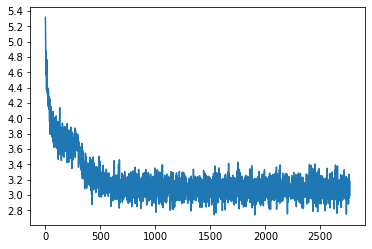

132m 21s (- 5m 42s) (278000 95%) 3.0887


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

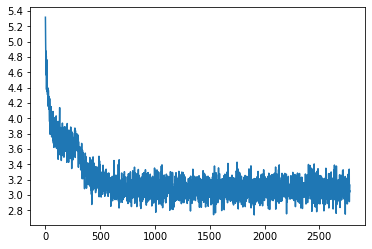

132m 50s (- 5m 14s) (279000 96%) 3.0524


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

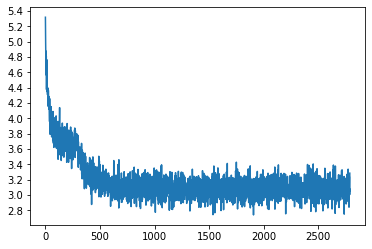

133m 18s (- 4m 45s) (280000 96%) 3.1035


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

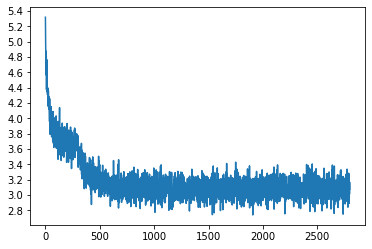

133m 46s (- 4m 17s) (281000 96%) 3.0854


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

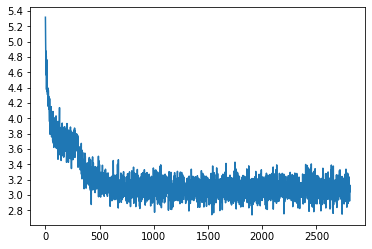

134m 15s (- 3m 48s) (282000 97%) 3.1073


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

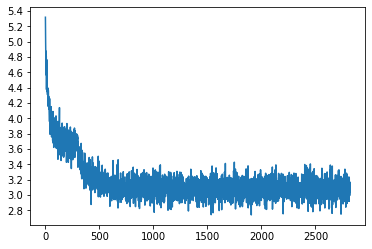

134m 43s (- 3m 19s) (283000 97%) 3.0343


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

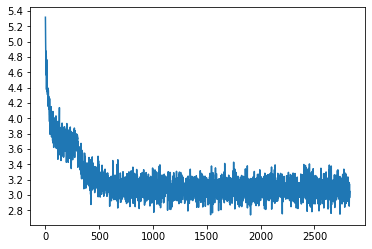

135m 12s (- 2m 51s) (284000 97%) 3.0339


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

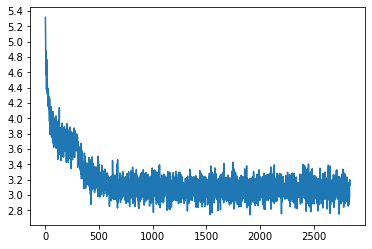

Epoch-24000 lr: 2.0000000000000012e-11
135m 41s (- 2m 22s) (285000 98%) 3.0058


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

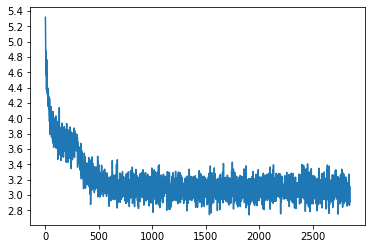

136m 10s (- 1m 54s) (286000 98%) 3.0264


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

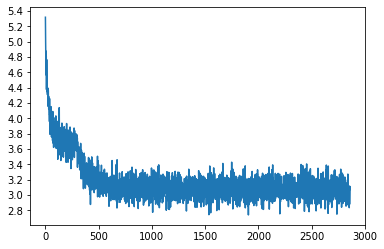

136m 39s (- 1m 25s) (287000 98%) 3.1192


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

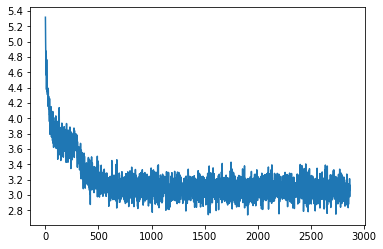

137m 9s (- 0m 57s) (288000 99%) 3.1236


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

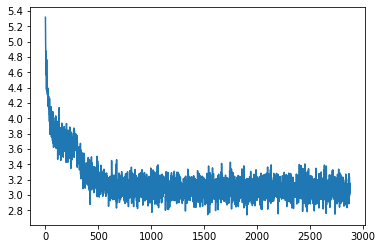

137m 38s (- 0m 28s) (289000 99%) 3.1067


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

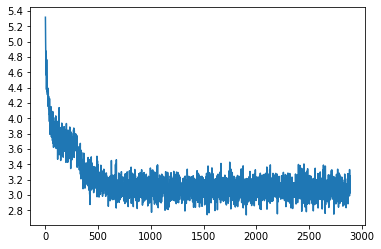

138m 7s (- 0m 0s) (290000 100%) 3.0700


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

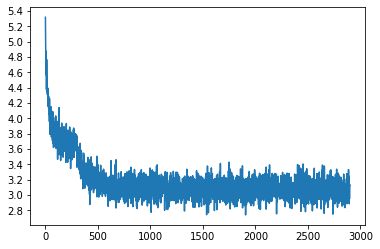

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

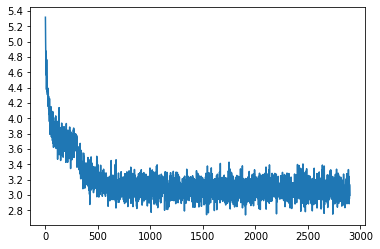

<Figure size 432x288 with 0 Axes>

In [43]:
%matplotlib inline

hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoder(hidden_size, output_lang.n_words, dropout_p=0.2).to(device)

trian_set_size = len(train_set)
trainIters(encoder1, attn_decoder1, EPOCH*trian_set_size, print_every=1000)

In [2]:
import torch
encoder_save = '/encoder0603_1.pth'
decoder_save = '/attn0603_1.pth'
torch.save(encoder1.state_dict(), encoder_save)
torch.save(attn_decoder1.state_dict(), decoder_save)

NameError: ignored

In [29]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

evaluateRandomly(encoder1, attn_decoder1)

> auf dieser belebten stra e in asien sind viele menschen .
= there are a lot of people on this busy asian street .
< one <EOS>

> mann auf hohem einrad in hellgelbem hemd rotem bandana und tarnhose jongliert mit drei kegeln wahrend leute zuschauen .
= man on a tall unicycle who is wearing bright yellow shirt red bandanna and camouflage pants is juggling pins while people watch .
< one <EOS>

> manner und frauen machen in einem offentlichen park yoga .
= men and women practice yoga in a public park .
< <EOS>

> ein kind sieht einer frau aufmerksam zu die ein macbook verwendet .
= a child watches intently as a woman uses a macbook laptop .
< one <EOS>

> ein junger mann mit einem rucksack tragt einen wei en pappkarton .
= a young man wearing a backpack is carrying a white cardboard box .
< <EOS>

> zwei kleine kinder klettern die stufen zu einem flugzeug hinauf .
= two small children climbing the steps onto a plane .
< one <EOS>

> ein alterer mann versucht herauszufinden was eine nahma

In [ ]:
"""
fail to run for now
"""
from BLEU.py import *
def run():
    source = '正因为你为你的玫瑰花费了时间,这才使你的玫瑰变得如此重要'  # source
    target = 'What makes your rose so important is the time you have wasted for it.'  # target
    inference = 'It is the time you have wasted for your rose that makes your rose so important.'  # inference
    bleu1 = BLEU(source, target, inference)
    bleu1.evaluate()
run()

ModuleNotFoundError: No module named 'jieba'